# 0 Импорты и библиотеки

## import

In [69]:
from dotenv import dotenv_values
from pathlib import Path
from pprint import pprint, pformat
import zipfile

import opendatasets as od 
import pandas as pd
import pandas.api.types as pd_types

import numpy as np

import plotly.express as plotly_px
import plotly.graph_objects as plotly_go
import plotly.subplots as plotly_subplt
import seaborn as sns
import matplotlib.pyplot as plt

import copy
import joblib

from dataclasses import dataclass
import builtins
from pathlib import Path
import time
import tqdm
import abc

In [70]:
from sklearn.model_selection import (
    train_test_split,  # Функция для разделения данных на обучающую и тестовую выборки
    cross_val_score, # оценщик кросс-валидации
    GridSearchCV,  # Класс для поиска гиперпараметров с помощью сеточного поиска
    RandomizedSearchCV
)

from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder
                                  )





## Библиотека

### BaseLib

In [71]:
class BaseLib():
    @staticmethod
    def st():
        """старт таймера"""
        return time.monotonic_ns()
    @staticmethod
    def ft(start):
        """финиш таймера и вывод времени"""
        duration = (time.monotonic_ns() - start) / 1000000000
        print(f'Затрачено времени: {duration:.2f} секунд')
        return duration

    @staticmethod
    def get_type(type_name):
        try:
            return getattr(builtins, type_name)
        except AttributeError:
            try:
                obj = globals()[type_name]
            except KeyError:
                return None
            return repr(obj) if isinstance(obj, type) else None

### DataSetLib

In [72]:
class DataSetLib():
    """Библиотека функций для работы с датасетом"""

    @staticmethod
    def columns_by_type(df, target_name, cat_treshold=2):
        """Сфромировать словарь, с разделением имен столбцов по типам:
        - target_columns - целевой столбец
        - columns_X - все столбцы-фичи
        - num_columns - числовые столбцы
        - cat_columns - категориальные. Категориальными считаютс и числовые столбцы, в которых уникальных значений меньше или равно  cat_treshold"""
        params = {}
        # columns_X - переменные датасета
        params["columns_X"] = df.columns.to_list()
        # целевой столбец
        params["target_column"] = target_name
        if target_name is not None:
            params["columns_X"].remove(params["target_column"])
        params["num_columns"] = []
        params["cat_columns"] = []
        # определить числовые и категориальные столбцы
        for col in params["columns_X"]:
            if df[col].nunique() <= cat_treshold or not pd_types.is_numeric_dtype(df[col]):
                params["cat_columns"].append(col)
            else:
                params["num_columns"].append(col)
        #print(f'target_columns={params["target_column"]}')        
        #print(f'columns_X={params["columns_X"]}')
        #print(f'cat_columns={pformat(params["cat_columns"])}')
        #print(f'num_columns={pformat(params["num_columns"])}')
        return params
    
    @staticmethod
    def remove_columns(params, column): 
        """удалить столбец и словаря параметров"""
        if column in params["columns_X"]:
            params["columns_X"].remove(column)
        if column in params["num_columns"]:
            params["num_columns"].remove(column)
        if column in params["cat_columns"]:
            params["cat_columns"].remove(column)
        return params

    @staticmethod
    def add_columns(params, column, type_column): 
        """добавить столбец в словарь параметров
        type_column = "cat" или "num" или None """
        if column not in params["columns_X"]:
            params["columns_X"].append(column)
        if type_column is None:
            pass
        elif type_column == "cat":
            params["cat_columns"].append(column)
        elif type_column == "num":
            params["num_columns"].append(column)
        else:
            raise ValueError("type_column должен быть 'cat' или 'num'")
        return params

    @staticmethod
    def describe_columns(df, params):
        """Отобразить описание содержимого столбцов"""    
        # подсчет столбцов с пропусками
        nan_in_columns = DataSetLib.nans_percents(df)
        
        print("Количество уникальных значений по столбцам, доля пропусков и уникальные значения, если их не более 10")
        nunique = df[params["columns_X"]].nunique()
        for column in nunique.index:
            if column in params["cat_columns"]:
                column_type = "[c]" # категориальные
            else:
                column_type = "[n]" # числовые
                
            if nan_in_columns[column] > 0:
                nan_str = f'({nan_in_columns[column]:4.1f}%)'
            else:
                nan_str = " "*7
            if nunique[column] <= 10:
                print(f'{column:20}{column_type}: {nunique[column]:6} {nan_str}, {df[column].unique().tolist()}')
            else:
                print(f'{column:20}{column_type}: {nunique[column]:6} {nan_str}')

        if params["target_column"] is not None:
            df_describe_num = DataSetLib.eda_df(df[params["num_columns"]+[params["target_column"]]])
        else:
            df_describe_num = DataSetLib.eda_df(df[params["num_columns"]])
        display(df_describe_num)            

        df_describe_cat = df[params["cat_columns"]].describe()
        display(df_describe_cat)

    @staticmethod
    def eda_df(df):
        """Провести EDA для датафрейма"""
        df_describe = df.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
        # посчитать долю пропусков
        df_describe.loc["%nan"] = (np.round(df[df_describe.columns].isna().mean()*100, 2)).to_list()
        # посчитать дисперсию
        columns_var = []
        for column in df_describe.columns:
            columns_var.append(df[column].var())
        df_describe.loc['var'] = columns_var
        return df_describe

    @staticmethod
    def show_boxes(df, columns, ncols = 3, type="box", row_height=500, total_width=1200):
        """Показать 'ящики_с_усами' для набора df.
        Ящики будут показаны для столбцов датафрема, перечисленных в columns.
        Графики будут показаны в несколько столбцов, количество которых задается в параметре ncols."""
        nrows = int(round((len(columns) + 0.5) / ncols, 0))
        nrows = nrows if nrows > 1 else 1

        if type == "box":
            title = "Ящики с усами"
        elif type == "hist":
            title = "Гистрограммы"
        elif type == "pie":
            title = "Пирожки"
        else:
            raise f"Не реализована обработка типа графика {type}"


        fig = plotly_subplt.make_subplots(rows=nrows, cols=ncols)
        fig.update_layout(
            title_x=0.5,
            title_text=title,
            height=row_height*nrows, 
            width=total_width
        )
        i = 0
        for r in range(nrows):
            for c in range(ncols):
                if type == "box":
                    fig.add_box(y=df[columns[i]], name=columns[i], row=r+1, col=c+1)
                elif type == "hist":
                    fig.add_histogram(x=df[columns[i]], name=columns[i], row=r+1, col=c+1)
                elif type == "pie":
                    fig.add_pie(df[columns[i]].value_counts().values,
                                labels=df[columns[i]].value_counts().index, 
                                name=columns[i], row=r+1, col=c+1)
                else:
                    raise f"Не реализована обработка типа графика {type}"
                i += 1
                if i >= len(columns):
                    break
            if i >= len(columns):
                break
        fig.show()          

    @staticmethod
    def show_boxes_plt(df, columns_x, ncols = 3, type="box", row_height=500, total_width=1200, column_y=None, filename=None):
        """Показать 'ящики_с_усами' для набора df.
        Ящики будут показаны для столбцов датафрема, перечисленных в columns.
        Графики будут показаны в несколько столбцов, количество которых задается в параметре ncols."""
        nrows = int(round((len(columns_x) + 0.59) / ncols, 0))
        nrows = nrows if nrows > 1 else 1

        if type == "box":
            title = "Ящики с усами"
        elif type == "hist":
            title = "Гистрограммы"
        elif type == "pie":
            title = "Пирожки"
        else:
            raise f"Не реализована обработка типа графика {type}"
                
        plt.figure(figsize=(ncols * 5, nrows * 3))
        
        for i, column in enumerate(columns_x, start=1):
            plt.subplot(nrows, ncols, i)
            if type == "box":
                if column_y is None:
                    sns.boxplot(x=df[column])
                else:
                    sns.boxplot(x=df[column], y=df[column_y])
            elif type == "hist":
                sns.histplot(df[column], kde=True)
            elif type == "pie":
                # define Seaborn color palette to use 
                palette_color = sns.color_palette("pastel") 
                # plotting data on chart 
                plt.pie(x=df[column].value_counts().values, 
                        labels=df[column].value_counts().index, 
                        colors=palette_color, autopct='%.0f%%') 
            else:
                raise f"Не реализована обработка типа графика {type}"
            # Добавить название столбца как заголовок графика
            plt.title(column)
        plt.tight_layout()
        if filename is not None:
            plt.savefig(filename, dpi=300)
        else:
            plt.show()
            
    @staticmethod            
    def iqr_values(values):
        """Границы для ящика-с-усами
        Возвращаемые значения: Q1, Q3, IQR, lower, upper
        """
        Q3 = np.quantile(values, 0.75, axis=0)
        Q1 = np.quantile(values, 0.25, axis=0)
        IQR = Q3 - Q1
        upper = Q3 + 1.5 * IQR
        lower = Q1 - 1.5 * IQR
        return Q1, Q3, IQR, lower, upper

        
    @staticmethod    
    def nans_percents(df):
        return df.isna().sum()/len(df)*100    

    @staticmethod
    def encode_features(src_df, onehot_cols=None, onehot_drop=None, ordinal_cols=None, columns_X=None):
        df = src_df.copy()  
        new_columns_X = copy.deepcopy(columns_X)
        if onehot_cols is not None:
            encoder = OneHotEncoder(sparse_output=False, drop=onehot_drop)
            one_hot_encoded = encoder.fit_transform(df[onehot_cols])
            one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(onehot_cols))
            df = pd.concat([df, one_hot_df], axis=1)
            new_columns_X += encoder.get_feature_names_out(onehot_cols).tolist()
            for col in onehot_cols:
                if col in columns_X:
                    new_columns_X.remove(col)
            df.drop(onehot_cols, axis=1, inplace=True)
            
        if ordinal_cols is not None:
            ordinal_columns_cats = list(ordinal_cols.values())
            ordinal_columns_list = list(ordinal_cols.keys())
            encoder = OrdinalEncoder(categories = ordinal_columns_cats)
            df[ordinal_columns_list] = encoder.fit_transform(df[ordinal_columns_list])  

        return df, new_columns_X

    @staticmethod
    def fill_with_mode(data, group_col, target_col):
        """Заполнить target_col модой внутри каждой группы столбцов group_col"""
        global_mode = data[target_col].mode()[0]
        def fill_group_mode(x):
            group_mode = x.mode()
            if not group_mode.empty:
                return group_mode[0]
            else:
                return global_mode
        data[target_col] = data.groupby(group_col)[target_col].transform(fill_group_mode)

    @staticmethod   
    def fill_with_mean(data, group_col, target_col):
        """Заполнить target_col средним внутри каждой группы столбцов group_col"""
        def fill_group_mean(x):
            return x.mean()
        data[target_col] = data.groupby(group_col)[target_col].transform(fill_group_mean)    
        # заполним глобальным средним, если что-то пропустилось
        data.fillna({target_col: data[target_col].mean()}, inplace=True)

    @staticmethod
    def prepare_dataset(dataset_df, params, scaler=None, train_size=0.7):
        """Разделить датасет на тренировочную и тестовую выборки и прогнать через нормализатор, если он указан"""
        X_train, X_test, y_train, y_test = train_test_split(dataset_df[params["columns_X"]], 
                                                            dataset_df[params["target_column"]], 
                                                            train_size=train_size, 
                                                            stratify=dataset_df[params["target_column"]],
                                                            random_state=42)
        # Нормировка признаков
        if scaler is not None:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)        
        return X_train, X_test, y_train, y_test


    @staticmethod
    def find_rows_with_nan(dataset_df, columns, debug=False):
        # сначала посмотрим на столбцы с измерениями 
        all_rows_with_nan = []
        rows_with_all_columns_nan = []
        for column in columns:
            nan_rows = dataset_df[dataset_df[column].isna()].index.to_list()
            if debug:
                print(f'Индексы строк с пустым {column}: {nan_rows}')
            all_rows_with_nan += nan_rows
            if rows_with_all_columns_nan == []:
                rows_with_all_columns_nan = nan_rows
            else:
                rows_with_all_columns_nan = list(set(rows_with_all_columns_nan) & set(nan_rows))
        # получить уникальный список индексов с пустыми столбцами
        all_rows_with_nan = list(set(all_rows_with_nan))    
        return rows_with_all_columns_nan, all_rows_with_nan        

### Settings

In [73]:
@dataclass 
class Settings():
    enviroment: object
    
    def __post_init__(self):
        self.dataset_folder = str(Path(Path.cwd(), self.enviroment["DATASET_SUBFOLDER"]))
        self.cache_folder = str(Path(Path.cwd(), self.enviroment["CACHE_SUBFOLDER"]))
        self.result_folder = str(Path(Path.cwd(), self.enviroment["RESULT_SUBFOLDER"]))
        
    def cache_gridsearch_filename(self, model_name): 
        return Path(self.cache_folder, self.enviroment["GRID_SEARCH_TEMPLATE_FILENAME"] % model_name)
    def cache_model_filename(self, model_name): 
        return Path(self.cache_folder, self.enviroment["MODEL_CLASS_TEMPLATE_FILENAME"] % model_name)
    def result_gridsearch_filename(self, model_name): 
        return Path(self.result_folder, self.enviroment["GRID_SEARCH_TEMPLATE_FILENAME"] % model_name) 
    def result_model_filename(self, model_name): 
        return Path(self.result_folder, self.enviroment["MODEL_CLASS_TEMPLATE_FILENAME"] % model_name)
    def result_trained_model_filename(self, model_name): 
        return Path(self.result_folder, self.enviroment["MODEL_CLASS_TEMPLATE_FILENAME"] % f'{model_name}_trained')             

### ModelWrapBase

In [74]:
class ModelWrapBase(abc.ABC):

    def __init__(self, name):
        self.name = name
        self.model_params = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

        self.model = None

    def create_model(self, model_class, model_params, X_train, X_test, y_train, y_test):
        self.model_params = model_params
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = model_class(**self.model_params)
    
    def fit(self):
        self.model.fit(self.X_train, self.y_train)    

    @abc.abstractmethod
    def calc_metrics(self):
        raise NotImplemented
    
    @abc.abstractmethod
    def show_quality(self): 
        raise NotImplemented
    
    @staticmethod
    def metrics_names():
        raise NotImplemented
    
    @staticmethod
    def metrics(self):
        raise NotImplemented

    @staticmethod
    def _load_or_create_and_fit_model(model_meta_class, 
                                      model_name, model_class, model_params, 
                                      X_train, X_test, y_train, y_test,
                                      settings, 
                                      need_save=True):
        """Загрузить ранее обученную модель из кеша.
        Если в кеше нет - обучить на переданных данных с заданными параметрами.
        """
        model_filename_cache = settings.cache_model_filename(model_name)
        model_filename = settings.result_model_filename(model_name)

        if Path.is_file(model_filename_cache):
            model = joblib.load(model_filename_cache)
            print(f"Модель {type(model.model).__name__} загружена из {model_filename_cache}")
        else:
            print(f"Создается и тренируется модель {model_name} класса {type(model_class).__name__}")
            print(f'Гиперпараметры модели: {model_params}')
            model = model_meta_class(model_name)
            model.create_model(model_class, model_params, X_train, X_test, y_train, y_test)
            model.fit()
            model.calc_metrics()
            if need_save:
                print(f"\nКласс-обвертка модели сохранен в {model_filename}")
                _ = joblib.dump(model, model_filename)
                print(f"\nНатренированная модель сохранена в {settings.result_trained_model_filename(model_name)}")
                _= joblib.dump(model.model, settings.result_trained_model_filename(model_name))
        return model
    
    @staticmethod
    def load_or_create_and_fit_GridSearchCV(model_name, model_class, param_grid, X_train, y_train,
                                             settings, 
                                             scoring='roc_auc', 
                                             need_save=True, n_jobs=None, verbose=1,
                                             use_randomize_search = True, n_iter=100):
        """Загрузить ранее обученные GridSearchCV из кеша. 
        Если в кеше нет - создать и потренировать, найдя лучшие гиперпараметры"""
        
        
        grid_search_filename_cache = settings.cache_gridsearch_filename(model_name)
        grid_search_filename = settings.result_gridsearch_filename(model_name)

        if Path.is_file(grid_search_filename_cache):
            print(f"GridSearchCV() загружен из {grid_search_filename_cache}")
            grid_search = joblib.load(grid_search_filename_cache)
        else:
            if use_randomize_search:
                print(f"Создается и выполняется RandomizedSearchCV для модели {model_name} класса {model_class.__name__}")
                grid_search = RandomizedSearchCV(model_class(), param_grid, cv=5, n_jobs=n_jobs, 
                                                 verbose=verbose, scoring=scoring,
                                                 random_state=settings.enviroment["RANDOM_STATE"],
                                                 n_iter=n_iter)
            else:
                print(f"Создается и выполняется GridSearchCV для модели {model_name} класса {model_class.__name__}")
                grid_search = GridSearchCV(model_class(), param_grid, cv=5, n_jobs=n_jobs, 
                                           verbose=verbose, scoring=scoring)
            
            # Обучаем модель на данных с использованием кросс-валидации
            grid_search.fit(X_train, y_train)
        
            if need_save:
                print(f"\nРезультаты поиска оптимальных гиперпараметров модели сохранены в {grid_search_filename}")
                _ = joblib.dump(grid_search, grid_search_filename)
        return grid_search    
    
    @staticmethod
    def compare_metrcis(model_wraps):
        """Сформировать датафрейм с метриками моделей из списка model_wraps"""
        df_metrics = []
        for model_wrap in model_wraps:
            df_metrics.append(pd.DataFrame(model_wrap.metrics()))

        df_stat = pd.concat(df_metrics)
        columns = ['model_name']
        columns = columns + model_wraps[0].metrics_names()
        df_stat2 = df_stat.pivot_table(columns = 'params',
                                        index='model_name',
                                        values='values').reset_index()[columns]
        return df_stat2


### ModelWrapRegression

In [75]:
# Наборы метрик для оценки моделей регрессии
from sklearn.metrics import (
    mean_squared_error,  # Средняя квадратичная ошибка для регрессии
    mean_absolute_error, 
    root_mean_squared_error, 
    r2_score  # Коэффициент детерминации для регрессии
)

In [76]:
class ModelWrapRegression(ModelWrapBase):
    
    def __init__(self, name):
        super().__init__(name)
        
        self.mse_train = None
        self.r2_train = None
        self.rmse_train = None
        self.mae_train = None

        self.mse_test = None
        self.r2_test = None
        self.rmse_test = None
        self.mae_test = None

    def calc_metrics(self):
        """Посчитать метрики модели"""
        self.y_train_pred = self.model.predict(self.X_train)
        self.y_test_pred = self.model.predict(self.X_test)
        
        self.mse_train = mean_squared_error(self.y_train, self.y_train_pred)
        self.r2_train = r2_score(self.y_train, self.y_train_pred)
        self.rmse_train = root_mean_squared_error(self.y_train, self.y_train_pred)
        self.mae_train = mean_absolute_error(self.y_train, self.y_train_pred)   
        self.median_train = self.y_train.median() 

        self.mse_test = mean_squared_error(self.y_test, self.y_test_pred)
        self.r2_test = r2_score(self.y_test, self.y_test_pred)
        self.rmse_test = root_mean_squared_error(self.y_test, self.y_test_pred)
        self.mae_test = mean_absolute_error(self.y_test, self.y_test_pred)    
        self.median_test = self.y_test.median() 
    
        
    def show_quality(self): 
        """Показать различные метрики"""
        print('Train data:')
        print(f"  MSE:    {round(self.mse_train,4)}")
        print(f"  RMSE:   {round(self.rmse_train,4)}")
        print(f"  MAE:    {round(self.mae_train,4)}")
        print(f"  r2:     {round(self.r2_train,4)}")
        print(f"  median: {round(self.median_train,4)}")

        print('Test data:')
        print(f"  MSE:    {round(self.mse_test,4)}")
        print(f"  RMSE:   {round(self.rmse_test,4)}")
        print(f"  MAE:    {round(self.mae_test,4)}")
        print(f"  r2:     {round(self.r2_test,4)}")    
        print(f"  median: {round(self.median_train,4)}")        
    
    @staticmethod
    def metrics_names():
        return ['Train_MSE', 'Test_MSE',
                'Train_RMSE', 'Test_RMSE',
                'Train_MAE', 'Test_MAE',
                'Train_R2', 'Test_R2',
                'Train_median', 'Test_Median'
                ]
    
    def metrics(self):
        """Сформировать словарь о сзначениями метрик модели"""
        metrics_as_dict = {
                'params': ModelWrapRegression.metrics_names(),
                'values': [
                    self.mse_train, self.mse_test,
                    self.rmse_train, self.rmse_test,
                    self.mae_train, self.mae_test,
                    self.r2_train, self.r2_test,
                    self.median_train, self.median_train
                ],
                'model_name': [self.name for i in range(len(ModelWrapRegression.metrics_names()))]
            }      
        return metrics_as_dict

    @staticmethod    
    def load_or_create_and_fit_model(model_name, model_class, model_params, 
                                    X_train, X_test, y_train, y_test,
                                    settings, 
                                    need_save=True):
        """Загрузить ранее обученную модель из кеша.
        Если в кеше нет - обучить на переданных данных с заданными параметрами.
        """
        return ModelWrapBase._load_or_create_and_fit_model(ModelWrapRegression, 
                                                       model_name, model_class, model_params, 
                                                       X_train, X_test, y_train, y_test,
                                                       settings, 
                                                       need_save)
    

### ModelWrapClassification

In [77]:
# Наборы метрик для оценки моделей классификации
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    roc_auc_score, 
    roc_curve, 
    f1_score,  #f1-мера
    accuracy_score,  # Метрика точности для классификации
    classification_report,  # Отчет о классификации
    confusion_matrix
)

In [78]:
class ModelWrapClass(ModelWrapBase):
    
    def __init__(self, name):
        super().__init__(name)

        self.train_precision = None
        self.test_precision = None
        self.train_recall = None
        self.test_recall = None
        self.train_roc_auc = None
        self.test_roc_auc = None
        self.train_accuracy = None
        self.test_accuracy = None
        self.train_f1_score = None
        self.test_f1_score = None
        self.specific_data = None
        self.y_train = None
        self.y_test = None
        self.y_train_proba = None
        self.y_test_proba = None

    def calc_metrics(self):
        """Посчитать метрики модели"""
        self.y_train_pred = self.model.predict(self.X_train)
        self.y_train_prob = self.model.predict_proba(self.X_train)[:, 1]
        self.y_test_pred = self.model.predict(self.X_test)
        self.y_test_prob = self.model.predict_proba(self.X_test)[:, 1]
    
        # матрица ошибок
        #self.conf_matrix_train = confusion_matrix(self.y_train, self.y_train_pred)
        #self.conf_matrix_test = confusion_matrix(self.y_test, self.y_test_pred)
        #self.conf_matrix_norm_train = confusion_matrix(self.y_train, self.y_train_pred, normalize='all')
        #self.conf_matrix_norm_test = confusion_matrix(self.y_test, self.y_test_pred, normalize='all')
        

        # Расчет AUC-ROC
        self.train_roc_auc = roc_auc_score(self.y_train, self.y_train_prob)
        self.test_roc_auc = roc_auc_score(self.y_test, self.y_test_prob)

        # Поиск порога, максимизирующего F1-score
        thresholds = np.arange(0.0, 1.0, 0.01)
        f1_scores = [f1_score(self.y_test, self.y_test_prob >= t) for t in thresholds]
        self.optimal_threshold = thresholds[np.argmax(f1_scores)]

        # Пересчет метрик с учетом оптимального порога
        self.y_train_pred_optimal = (self.y_train_prob >= self.optimal_threshold).astype(int)
        self.y_test_pred_optimal = (self.y_test_prob >= self.optimal_threshold).astype(int)

        self.train_precision = precision_score(self.y_train, self.y_train_pred_optimal)
        self.test_precision = precision_score(self.y_test, self.y_test_pred_optimal)

        self.train_recall = recall_score(self.y_train, self.y_train_pred_optimal)
        self.test_recall = recall_score(self.y_test, self.y_test_pred_optimal)

        self.train_accuracy = accuracy_score(self.y_train, self.y_train_pred_optimal)
        self.test_accuracy = accuracy_score(self.y_test, self.y_test_pred_optimal)

        self.train_f1_score = f1_score(self.y_train, self.y_train_pred_optimal)
        self.test_f1_score = f1_score(self.y_test, self.y_test_pred_optimal)
        
    def show_quality(self): #X_train, X_test, y_train, y_test, check_result, title, grid_search, model_cl):
        """Показать различные метрики и промежуточные переменные обучения"""
        #def show_quality2(X_train, X_test, y_train, y_test, check_result, title, grid_search, model_cl):
        fig = plotly_subplt.make_subplots(rows=2, cols=2, 
                                        subplot_titles=['ROC AUC', 'Metrics', 'Confusion Matrix Train', 'Confusion Matrix Test'],
                                        vertical_spacing = 0.1,
                                        row_width=[0.4, 0.6])
        fig.update_layout(
            title_x=0.5,
            title_text=self.name,
            width = 1000,
            height = 800,
            legend = dict(yanchor="bottom", y=0.63, xanchor="right", x=0.44),
            margin = {'t':80, 'b':50, 'l':10, 'r':10}
            
        )

        # Построение ROC кривой
        fpr_test, tpr_test, thresholds = roc_curve(self.y_test, self.y_test_prob)
        fpr_train, tpr_train, thresholds = roc_curve(self.y_train, self.y_train_prob)
        roc_train_g = plotly_go.Scatter(x=fpr_train, y=tpr_train, name="ROC curve Train", line={'color':'green'})
        roc_test_g = plotly_go.Scatter(x=fpr_test, y=tpr_test, name="ROC curve Test", line={'color':'blue'})
        roc_diag_g = plotly_go.Scatter(x=[0, 1], y=[0, 1], line={'color':'gray', 'dash': 'dash'}, showlegend=False)

        fig.add_trace(roc_train_g, row=1, col=1)
        fig.add_trace(roc_test_g, row=1, col=1)
        fig.add_trace(roc_diag_g, row=1, col=1)
        
        fig.update_layout(
            xaxis1 = {'title_text': "False Positive Rate"},
            yaxis1 = {'title_text': "True Positive Rate"}
        )    
        

        # Bar с метриками
        df_metrics = pd.DataFrame([[self.test_accuracy,  self.train_accuracy],
                                   [self.test_precision, self.train_precision],
                                   [self.test_recall,    self.train_recall],
                                   [self.test_roc_auc,   self.train_roc_auc],
                                   [self.test_f1_score,  self.train_f1_score]], 
                                  columns = ["Test", "Train"], 
                                  index=["accuracy", "precision", "recall", "ROC AUC", "F1"])
        metrics_train = plotly_go.Bar(x=df_metrics.index, y=df_metrics.Train, 
                        showlegend=True, text=round(df_metrics.Train,4), textangle=0, 
                        xaxis='x2', yaxis='y2', name="Train Metrics")
        metrics_test = plotly_go.Bar(x=df_metrics.index, y=df_metrics.Test, 
                        showlegend=True, text=round(df_metrics.Test,4), textangle=0, 
                        xaxis='x2', yaxis='y2', name="Test Metrics")

        fig.add_trace(metrics_train, row=1, col=2) 
        fig.add_trace(metrics_test, row=1, col=2) 

        # Confusion Matrix 
        """
        cm_normalized_train = self.conf_matrix_train.astype('float') / self.conf_matrix_train.sum(axis=1)[:, np.newaxis]
        print(self.conf_matrix_train.astype('float'))
        print(self.conf_matrix_train.sum(axis=1).astype('float'))
        print(cm_normalized_train)
        heatmap_train = plotly_go.Heatmap(z=cm_normalized_train, x=['0', '1'], y=['0', '1'], colorscale='Blues', 
                                        text=np.round(cm_normalized_train, 3), texttemplate="%{text}", showscale=False)

        cm_normalized_test = self.conf_matrix_test.astype('float') / self.conf_matrix_test.sum(axis=1)[:, np.newaxis]
        heatmap_test = plotly_go.Heatmap(z=cm_normalized_test, x=['0', '1'], y=['0', '1'], colorscale='Blues', 
                                        text=np.round(cm_normalized_test, 3), texttemplate="%{text}", showscale=False)
        """


        train_cm = confusion_matrix(self.y_train, self.y_train_pred_optimal, normalize='all')
        heatmap_train = plotly_go.Heatmap(z=train_cm, 
                                          x=['0', '1'], y=['0', '1'], 
                                          colorscale='Blues', 
                                          text=np.round(train_cm, 3), 
                                          texttemplate="%{text}", 
                                          showscale=False)

        test_cm = confusion_matrix(self.y_test, self.y_test_pred_optimal, normalize='all')
        heatmap_test = plotly_go.Heatmap(z=test_cm, 
                                         x=['0', '1'], y=['0', '1'], 
                                         colorscale='Blues', 
                                         text=np.round(test_cm, 3), 
                                         texttemplate="%{text}", 
                                         showscale=False)


        fig.add_trace(heatmap_train, row=2, col=1)
        fig.add_trace(heatmap_test,  row=2, col=2) 

        fig.update_layout(
            xaxis1 = {'title': 'Predict'},
            xaxis2 = {'title': 'Predict'},
            yaxis1 = {'title': 'Goals'},
            yaxis2 = {'title': 'Goals'},
            xaxis3 = {'title': 'Предсказания'},
            xaxis4 = {'title': 'Предсказания'},
            yaxis3 = {'title': 'Факт'},
            yaxis4 = {'title': 'Факт'},
                        
        )    
        
        fig.show()
    
    @staticmethod
    def metrics_names():
        return ['Training_Precision', 'Test_Precision',
                'Training_Recall', 'Test_Recall',
                'ROC_AUC_Train', 'ROC_AUC_Test',
                'Accuarcy_Train', 'Accuarcy_Test',
                'F1_score_Train', 'F1_score_Test'
                ]
    
    def metrics(self):
        """Сформировать словарь о сзначениями метрик модели"""
        metrics_as_dict = {
                'params': ModelWrapClass.metrics_names(),
                'values': [
                    self.train_precision, self.test_precision,
                    self.train_recall, self.test_recall,
                    self.train_roc_auc, self.test_roc_auc,
                    self.train_accuracy, self.test_accuracy,
                    self.train_f1_score, self.test_f1_score
                ],
                'model_name': [self.name for i in range(len(ModelWrapClass.metrics_names()))]
            }      
        return metrics_as_dict

    @staticmethod    
    def load_or_create_and_fit_model(model_name, model_class, model_params, 
                                    X_train, X_test, y_train, y_test,
                                    settings, 
                                    need_save=True):
        """Загрузить ранее обученную модель из кеша.
        Если в кеше нет - обучить на переданных данных с заданными параметрами.
        """
        return ModelWrapBase._load_or_create_and_fit_model(ModelWrapClass, 
                                                       model_name, model_class, model_params, 
                                                       X_train, X_test, y_train, y_test,
                                                       settings, 
                                                       need_save)


In [79]:
class ModelWrapRegression(ModelWrapBase):
    
    def __init__(self, name):
        super().__init__(name)
        
        self.mse_train = None
        self.r2_train = None
        self.rmse_train = None
        self.mae_train = None

        self.mse_test = None
        self.r2_test = None
        self.rmse_test = None
        self.mae_test = None

    def calc_metrics(self):
        """Посчитать метрики модели"""
        self.y_train_pred = self.model.predict(self.X_train)
        self.y_test_pred = self.model.predict(self.X_test)
        
        self.mse_train = mean_squared_error(self.y_train, self.y_train_pred)
        self.r2_train = r2_score(self.y_train, self.y_train_pred)
        self.rmse_train = root_mean_squared_error(self.y_train, self.y_train_pred)
        self.mae_train = mean_absolute_error(self.y_train, self.y_train_pred)   
        self.median_train = self.y_train.median() 

        self.mse_test = mean_squared_error(self.y_test, self.y_test_pred)
        self.r2_test = r2_score(self.y_test, self.y_test_pred)
        self.rmse_test = root_mean_squared_error(self.y_test, self.y_test_pred)
        self.mae_test = mean_absolute_error(self.y_test, self.y_test_pred)    
        self.median_test = self.y_test.median() 
    
        
    def show_quality(self): 
        """Показать различные метрики"""
        print('Train data:')
        print(f"  MSE:    {round(self.mse_train,4)}")
        print(f"  RMSE:   {round(self.rmse_train,4)}")
        print(f"  MAE:    {round(self.mae_train,4)}")
        print(f"  r2:     {round(self.r2_train,4)}")
        print(f"  median: {round(self.median_train,4)}")

        print('Test data:')
        print(f"  MSE:    {round(self.mse_test,4)}")
        print(f"  RMSE:   {round(self.rmse_test,4)}")
        print(f"  MAE:    {round(self.mae_test,4)}")
        print(f"  r2:     {round(self.r2_test,4)}")    
        print(f"  median: {round(self.median_train,4)}")        
    
    @staticmethod
    def metrics_names():
        return ['Train_MSE', 'Test_MSE',
                'Train_RMSE', 'Test_RMSE',
                'Train_MAE', 'Test_MAE',
                'Train_R2', 'Test_R2',
                'Train_median', 'Test_Median'
                ]
    
    def metrics(self):
        """Сформировать словарь о сзначениями метрик модели"""
        metrics_as_dict = {
                'params': ModelWrapRegression.metrics_names(),
                'values': [
                    self.mse_train, self.mse_test,
                    self.rmse_train, self.rmse_test,
                    self.mae_train, self.mae_test,
                    self.r2_train, self.r2_test,
                    self.median_train, self.median_train
                ],
                'model_name': [self.name for i in range(len(ModelWrapRegression.metrics_names()))]
            }      
        return metrics_as_dict

    @staticmethod    
    def load_or_create_and_fit_model(model_name, model_class, model_params, 
                                    X_train, X_test, y_train, y_test,
                                    settings, 
                                    need_save=True):
        """Загрузить ранее обученную модель из кеша.
        Если в кеше нет - обучить на переданных данных с заданными параметрами.
        """
        return ModelWrapBase._load_or_create_and_fit_model(ModelWrapRegression, 
                                                       model_name, model_class, model_params, 
                                                       X_train, X_test, y_train, y_test,
                                                       settings, 
                                                       need_save)


## Конфигурирование среды и окружения

In [80]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50) # Устанавливаем максимальное количество отображаемых столбцов равным 50
#pd.set_option('display.max_rows', 50) # Устанавливаем максимальное количество отображаемых строк равным 20
pd.options.display.float_format = '{:.5f}'.format # Устанавливаем формат отображения чисел с двумя знаками после запятой
pd.options.mode.use_inf_as_na = True # Настройка режима Pandas для рассмотрения бесконечностей (inf) как пропущенных значений (NA)

# Конфигурация формата отображения графиков в виде векторных изображений
%config InlineBackend.figure_format = 'svg'

# для построения графиков внутри Jupyter Notebook
%matplotlib inline

In [81]:
settings_filename = "settings"

In [82]:
if not Path(settings_filename).exists():
    with open(settings_filename, "w") as f:
        f.write("""# Каталог с датасетом
DATASET_SUBFOLDER=dataset
# Каталог для результатов и промежуточных файлов
RESULT_SUBFOLDER=result
# Каталог для кеша промежуточных результатов
CACHE_SUBFOLDER=cached_results
# Каталог для boxplot
BOXPLOT_SUBFOLDER=boxplot

RANDOM_STATE=42

DATASET_FILENAME_TEMPLATE=dataset_df_%s.joblib
PARAMS_FILENAME_TEMPLATE=params_%s.joblib

X_Train_FILENAME_TEMPLATE=X_Train_%s.joblib
y_Train_FILENAME_TEMPLATE=y_Train_%s.joblib
X_Test_FILENAME_TEMPLATE=X_Test_%s.joblib
y_Test_FILENAME_TEMPLATE=y_Test_%s.joblib


# Шаблоны для имен
GRID_SEARCH_TEMPLATE_FILENAME=03_GridSearch_%s.joblib
MODEL_CLASS_TEMPLATE_FILENAME=04_model_%s.joblib""")
        

In [83]:
# загрузить параметры
settings_dict = {
    **dotenv_values(settings_filename)
}

settings = Settings(settings_dict)
settings.enviroment["RANDOM_STATE"] = int(settings.enviroment["RANDOM_STATE"])
n_jobs = -1
verbose = 1
load_from_kaggle = False

In [84]:
settings.enviroment

{'DATASET_SUBFOLDER': 'dataset',
 'RESULT_SUBFOLDER': 'result',
 'CACHE_SUBFOLDER': 'cached_results',
 'BOXPLOT_SUBFOLDER': 'boxplot',
 'RANDOM_STATE': 42,
 'DATASET_FILENAME_TEMPLATE': 'dataset_df_%s.joblib',
 'PARAMS_FILENAME_TEMPLATE': 'params_%s.joblib',
 'X_Train_FILENAME_TEMPLATE': 'X_Train_%s.joblib',
 'y_Train_FILENAME_TEMPLATE': 'y_Train_%s.joblib',
 'X_Test_FILENAME_TEMPLATE': 'X_Test_%s.joblib',
 'y_Test_FILENAME_TEMPLATE': 'y_Test_%s.joblib',
 'GRID_SEARCH_TEMPLATE_FILENAME': '03_GridSearch_%s.joblib',
 'MODEL_CLASS_TEMPLATE_FILENAME': '04_model_%s.joblib'}

# 1. Загрузка датасета

In [85]:
# загрузить датасет если его нет
csv_filename = Path(settings.enviroment["DATASET_SUBFOLDER"], "playground-series-s4e12", 'train.csv')
if not Path(csv_filename).exists():
    if not Path(settings.enviroment["DATASET_SUBFOLDER"]).exists():
        Path.mkdir(Path(settings.enviroment["DATASET_SUBFOLDER"]))
    od.download_kaggle_dataset("https://www.kaggle.com/competitions/playground-series-s4e12/data", 
                               Path(settings.enviroment["DATASET_SUBFOLDER"]))

In [86]:
# Загрузим датасет и для ДЗ отберем 5000 строк из датасета
original_dataset_df = pd.read_csv(csv_filename, index_col="id").\
                         sample(5000, random_state=settings.enviroment["RANDOM_STATE"]).\
                         reset_index(drop=True)
dataset_df = original_dataset_df.copy()

# 2. EDA датасета

## Обзор датасета

In [87]:
display(dataset_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   4921 non-null   float64
 1   Gender                5000 non-null   object 
 2   Annual Income         4814 non-null   float64
 3   Marital Status        4928 non-null   object 
 4   Number of Dependents  4533 non-null   float64
 5   Education Level       5000 non-null   object 
 6   Occupation            3533 non-null   object 
 7   Health Score          4694 non-null   float64
 8   Location              5000 non-null   object 
 9   Policy Type           5000 non-null   object 
 10  Previous Claims       3457 non-null   float64
 11  Vehicle Age           5000 non-null   float64
 12  Credit Score          4398 non-null   float64
 13  Insurance Duration    5000 non-null   float64
 14  Policy Start Date     5000 non-null   object 
 15  Customer Feedback    

None

In [88]:
dataset_df.describe(include='all')

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
count,4921.00000,5000,4814.00000,4928,4533.00000,5000,3533,4694.00000,5000,5000,3457.00000,5000.00000,4398.00000,5000.00000,5000,4676,5000,5000,5000,5000.00000
unique,NaN,2,NaN,3,NaN,4,3,NaN,3,3,NaN,NaN,NaN,NaN,4814,3,2,4,3,NaN
top,NaN,Male,NaN,Married,NaN,Bachelor's,Employed,NaN,Rural,Premium,NaN,NaN,NaN,NaN,2020-01-29 15:21:39.155231,Poor,Yes,Weekly,Apartment,NaN
freq,NaN,2521,NaN,1693,NaN,1332,1229,NaN,1685,1729,NaN,NaN,NaN,NaN,3,1591,2518,1261,1735,NaN
mean,41.30482,NaN,33353.26651,NaN,2.02294,NaN,NaN,25.27287,NaN,NaN,0.99711,9.46740,586.43315,5.00180,NaN,NaN,NaN,NaN,NaN,1080.93600
std,13.55396,NaN,32456.97293,NaN,1.41886,NaN,NaN,12.30217,NaN,NaN,0.98042,5.73127,151.31486,2.58022,NaN,NaN,NaN,NaN,NaN,863.47215
min,18.00000,NaN,17.00000,NaN,0.00000,NaN,NaN,3.04978,NaN,NaN,0.00000,0.00000,300.00000,1.00000,NaN,NaN,NaN,NaN,NaN,20.00000
25%,30.00000,NaN,8072.00000,NaN,1.00000,NaN,NaN,15.46478,NaN,NaN,0.00000,5.00000,463.00000,3.00000,NaN,NaN,NaN,NaN,NaN,492.75000
50%,41.00000,NaN,24881.00000,NaN,2.00000,NaN,NaN,24.02711,NaN,NaN,1.00000,10.00000,585.00000,5.00000,NaN,NaN,NaN,NaN,NaN,843.50000
75%,53.00000,NaN,45015.00000,NaN,3.00000,NaN,NaN,34.06799,NaN,NaN,2.00000,14.00000,718.00000,7.00000,NaN,NaN,NaN,NaN,NaN,1471.00000


In [89]:
display(dataset_df.sample(7, random_state=settings.enviroment["RANDOM_STATE"]))

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
1501,22.00000,Female,95744.00000,Single,1.00000,Bachelor's,Self-Employed,12.29605,Suburban,Premium,0.00000,1.00000,397.00000,1.00000,2023-01-04 15:21:39.211806,Good,No,Daily,House,951.00000
2586,58.00000,Female,20892.00000,Married,1.00000,Master's,Employed,19.82591,Suburban,Basic,1.00000,1.00000,728.00000,3.00000,2021-06-18 15:21:39.143708,NaN,Yes,Rarely,Apartment,916.00000
2653,21.00000,Male,104258.00000,Married,1.00000,PhD,NaN,27.72637,Rural,Basic,1.00000,10.00000,400.00000,5.00000,2020-11-05 15:21:39.146733,Good,No,Monthly,Apartment,1418.00000
1055,38.00000,Female,5372.00000,Married,0.00000,Bachelor's,NaN,27.91096,Urban,Premium,0.00000,18.00000,593.00000,2.00000,2020-08-16 15:21:39.175719,Average,Yes,Daily,House,1129.00000
705,47.00000,Female,18059.00000,Divorced,2.00000,Master's,NaN,49.30224,Suburban,Comprehensive,1.00000,1.00000,390.00000,7.00000,2023-01-28 15:21:39.204790,Poor,Yes,Monthly,House,1527.00000
106,40.00000,Female,11278.00000,Divorced,0.00000,Master's,Employed,15.00199,Suburban,Premium,NaN,7.00000,434.00000,9.00000,2022-07-06 15:21:39.155231,Average,Yes,Monthly,Apartment,542.00000
589,34.00000,Female,41008.00000,Married,3.00000,PhD,Employed,46.89084,Rural,Premium,0.00000,11.00000,NaN,6.00000,2019-11-11 15:21:39.134960,Poor,Yes,Rarely,Apartment,2832.00000


In [90]:
params = DataSetLib.columns_by_type(dataset_df, "Premium Amount")
DataSetLib.describe_columns(dataset_df, params)

Количество уникальных значений по столбцам, доля пропусков и уникальные значения, если их не более 10
Age                 [n]:     47 ( 1.6%)
Gender              [c]:      2        , ['Female', 'Male']
Annual Income       [n]:   3922 ( 3.7%)
Marital Status      [c]:      3 ( 1.4%), ['Married', 'Divorced', 'Single', nan]
Number of Dependents[n]:      5 ( 9.3%), [nan, 4.0, 2.0, 0.0, 3.0, 1.0]
Education Level     [c]:      4        , ["Master's", "Bachelor's", 'PhD', 'High School']
Occupation          [c]:      3 (29.3%), ['Employed', nan, 'Unemployed', 'Self-Employed']
Health Score        [n]:   4622 ( 6.1%)
Location            [c]:      3        , ['Rural', 'Suburban', 'Urban']
Policy Type         [c]:      3        , ['Basic', 'Comprehensive', 'Premium']
Previous Claims     [n]:      7 (30.9%), [0.0, 2.0, 1.0, nan, 3.0, 4.0, 5.0, 6.0]
Vehicle Age         [n]:     20        
Credit Score        [n]:    548 (12.0%)
Insurance Duration  [n]:      9        , [3.0, 7.0, 5.0, 4.0, 9.0, 2.0, 1

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
count,4921.00000,4814.00000,4533.00000,4694.00000,3457.00000,5000.00000,4398.00000,5000.00000,5000.00000
mean,41.30482,33353.26651,2.02294,25.27287,0.99711,9.46740,586.43315,5.00180,1080.93600
std,13.55396,32456.97293,1.41886,12.30217,0.98042,5.73127,151.31486,2.58022,863.47215
min,18.00000,17.00000,0.00000,3.04978,0.00000,0.00000,300.00000,1.00000,20.00000
10%,22.00000,2662.30000,0.00000,9.69194,0.00000,2.00000,380.00000,1.00000,150.90000
25%,30.00000,8072.00000,1.00000,15.46478,0.00000,5.00000,463.00000,3.00000,492.75000
50%,41.00000,24881.00000,2.00000,24.02711,1.00000,10.00000,585.00000,5.00000,843.50000
75%,53.00000,45015.00000,3.00000,34.06799,2.00000,14.00000,718.00000,7.00000,1471.00000
90%,60.00000,82291.50000,4.00000,43.22818,2.00000,17.00000,790.00000,9.00000,2323.00000
max,64.00000,149995.00000,4.00000,55.95714,6.00000,19.00000,849.00000,9.00000,4970.00000


,Gender,Marital Status,Education Level,Occupation,Location,Policy Type,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
count,5000,4928,5000,3533,5000,5000,5000,4676,5000,5000,5000
unique,2,3,4,3,3,3,4814,3,2,4,3
top,Male,Married,Bachelor's,Employed,Rural,Premium,2020-01-29 15:21:39.155231,Poor,Yes,Weekly,Apartment
freq,2521,1693,1332,1229,1685,1729,3,1591,2518,1261,1735


## Обработка пропусков пропусков 

В фичах Occupation и Previous Claims слишком много пропуском - эти фичи удалим.

Остальные заполним:
  * Age - средним
  * Annual Income - средним внутри групп по столбцам ['Education Level', 'Location', 'Property Type']
  * Marital Status - модой внутри групп пос столбцам ['Age', 'Gender', 'Annual Income', 'Education Level']
  * Number of Dependents - модой внутри групп по столбцам ['Age', 'Annual Income', 'Marital Status', 'Education Level', 'Location']
  * Health Score - средним внутри групп по столбцам ['Age', 'Gender', 'Education Level', 'Smoking Status', 'Exercise Frequency']
  * Credit Score - средним внутри групп по столбцам ['Education Level', 'Location', 'Property Type', 'Annual Income']
  * Customer Feedback - модой внутри групп по столбцам ['Education Level', 'Policy Type', 'Policy Start Date', 'Gender']

In [91]:
dataset_df_wo_nan = dataset_df.copy()

dataset_df_wo_nan.fillna({'Age': dataset_df['Age'].mean()}, inplace=True)
DataSetLib.fill_with_mean(dataset_df_wo_nan, ['Education Level', 'Location', 'Property Type'], 'Annual Income')
DataSetLib.fill_with_mode(dataset_df_wo_nan, ['Age', 'Gender', 'Annual Income', 'Education Level'], 'Marital Status')
DataSetLib.fill_with_mode(dataset_df_wo_nan, ['Age', 'Annual Income', 'Marital Status', 'Education Level', 'Location'], 'Number of Dependents')
DataSetLib.fill_with_mean(dataset_df_wo_nan, ['Age', 'Gender', 'Education Level', 'Smoking Status', 'Exercise Frequency'], 'Health Score')
DataSetLib.fill_with_mean(dataset_df_wo_nan, ['Education Level', 'Location', 'Property Type', 'Annual Income'], 'Credit Score')
DataSetLib.fill_with_mode(dataset_df_wo_nan, ['Education Level', 'Policy Type', 'Policy Start Date', 'Gender'], 'Customer Feedback')
dataset_df_wo_nan.drop('Occupation', axis=1, inplace=True)
dataset_df_wo_nan.drop('Previous Claims', axis=1, inplace=True)
DataSetLib.remove_columns(params, "Occupation");
DataSetLib.remove_columns(params, "Previous Claims");

In [92]:
DataSetLib.describe_columns(dataset_df_wo_nan, params)

Количество уникальных значений по столбцам, доля пропусков и уникальные значения, если их не более 10
Age                 [n]:     48        
Gender              [c]:      2        , ['Female', 'Male']
Annual Income       [n]:     36        
Marital Status      [c]:      3        , ['Married', 'Divorced', 'Single']
Number of Dependents[n]:      5        , [3.0, 4.0, 2.0, 0.0, 1.0]
Education Level     [c]:      4        , ["Master's", "Bachelor's", 'PhD', 'High School']
Health Score        [n]:   2406        
Location            [c]:      3        , ['Rural', 'Suburban', 'Urban']
Policy Type         [c]:      3        , ['Basic', 'Comprehensive', 'Premium']
Vehicle Age         [n]:     20        
Credit Score        [n]:     36        
Insurance Duration  [n]:      9        , [3.0, 7.0, 5.0, 4.0, 9.0, 2.0, 1.0, 6.0, 8.0]
Policy Start Date   [c]:   4814        
Customer Feedback   [c]:      3        , ['Average', 'Poor', 'Good']
Smoking Status      [c]:      2        , ['No', 'Yes']
Exer

,Age,Annual Income,Number of Dependents,Health Score,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
count,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000
mean,41.30482,33358.10626,1.58400,25.29212,9.46740,586.30962,5.00180,1080.93600
std,13.44644,3259.81792,1.42427,8.66131,5.73127,12.25992,2.58022,863.47215
min,18.00000,25565.92063,0.00000,3.24680,0.00000,556.13514,1.00000,20.00000
10%,22.00000,29313.09630,0.00000,14.62840,2.00000,566.73134,1.00000,150.90000
25%,30.00000,30776.82993,0.00000,19.78464,5.00000,577.50394,3.00000,492.75000
50%,41.30482,33607.31293,1.00000,25.04081,10.00000,587.35772,5.00000,843.50000
75%,53.00000,36252.62676,3.00000,30.37088,14.00000,593.90654,7.00000,1471.00000
90%,60.00000,36628.33577,4.00000,36.85578,17.00000,600.09924,9.00000,2323.00000
max,64.00000,40256.18462,4.00000,53.39451,19.00000,610.33333,9.00000,4970.00000


,Gender,Marital Status,Education Level,Location,Policy Type,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
count,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000
unique,2,3,4,3,3,4814,3,2,4,3
top,Male,Divorced,Bachelor's,Rural,Premium,2020-01-29 15:21:39.155231,Poor,Yes,Weekly,Apartment
freq,2521,2241,1332,1685,1729,3,1913,2518,1261,1735


In [93]:
dataset_df = dataset_df_wo_nan
dataset_df_wo_nan = None

## Policy Start Date

In [94]:
# Разобрать дату старта полису на год, месяц, день и день недели
dataset_df['Policy Start Date'] = pd.to_datetime(dataset_df['Policy Start Date'])

dataset_df['Policy Start Year'] = dataset_df['Policy Start Date'].dt.year
dataset_df['Policy Start Month'] = dataset_df['Policy Start Date'].dt.month
dataset_df['Policy Start Day'] = dataset_df['Policy Start Date'].dt.day
dataset_df['Policy Start Weekday'] = dataset_df['Policy Start Date'].dt.weekday 

dataset_df.drop(columns=['Policy Start Date'], inplace=True)
DataSetLib.remove_columns(params, "Policy Start Date");
DataSetLib.add_columns(params, "Policy Start Year", "num");
DataSetLib.add_columns(params, "Policy Start Month", "num");
DataSetLib.add_columns(params, "Policy Start Day", "num");
DataSetLib.add_columns(params, "Policy Start Weekday", "num");
display(dataset_df.sample(7))


,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Health Score,Location,Policy Type,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Policy Start Year,Policy Start Month,Policy Start Day,Policy Start Weekday
997,52.00000,Female,34218.70992,Single,2.00000,High School,26.71009,Suburban,Basic,1.00000,587.30000,3.00000,Good,No,Weekly,Condo,1034.00000,2020,5,30,5
1748,58.00000,Male,34218.70992,Married,1.00000,High School,50.73595,Suburban,Premium,1.00000,587.30000,5.00000,Good,Yes,Daily,Condo,623.00000,2020,4,8,2
649,20.00000,Female,36252.62676,Married,4.00000,High School,18.01516,Rural,Basic,5.00000,580.90756,5.00000,Average,No,Weekly,Condo,101.00000,2023,12,11,0
3503,63.00000,Male,32468.94444,Divorced,1.00000,Bachelor's,21.62337,Rural,Comprehensive,12.00000,577.50394,1.00000,Poor,Yes,Daily,House,2732.00000,2020,11,24,1
2001,59.00000,Male,30776.82993,Married,0.00000,Bachelor's,11.60191,Rural,Comprehensive,4.00000,601.90299,5.00000,Average,Yes,Monthly,Apartment,698.00000,2023,9,20,2
3774,31.00000,Male,34442.70833,Divorced,0.00000,Master's,13.86309,Urban,Premium,4.00000,575.49074,5.00000,Good,No,Rarely,Condo,359.00000,2020,6,21,6
2027,64.00000,Female,32082.41844,Married,0.00000,Bachelor's,29.20167,Urban,Comprehensive,14.00000,587.35772,5.00000,Poor,No,Rarely,House,1934.00000,2023,8,10,3


## Прочие категориальные переменные

In [95]:
print("Набор значений категориальных столбцов:")
for col in params["cat_columns"]:
    #print(f'{dataset_df_wo_nan[col].value_counts()}')
    print(f'{col}: {dataset_df[col].unique().tolist()}')

Набор значений категориальных столбцов:
Gender: ['Female', 'Male']
Marital Status: ['Married', 'Divorced', 'Single']
Education Level: ["Master's", "Bachelor's", 'PhD', 'High School']
Location: ['Rural', 'Suburban', 'Urban']
Policy Type: ['Basic', 'Comprehensive', 'Premium']
Customer Feedback: ['Average', 'Poor', 'Good']
Smoking Status: ['No', 'Yes']
Exercise Frequency: ['Weekly', 'Monthly', 'Rarely', 'Daily']
Property Type: ['Apartment', 'House', 'Condo']


In [96]:
# Столбцы для one-hot-encoding
onehot_columns = ['Gender', "Marital Status", "Location", "Property Type", "Smoking Status"]
# Столбцы для ordinal-encoding
ordered_columns = {"Education Level": ["High School", "Bachelor's", "Master's", "PhD"],
                   "Policy Type": ['Basic', 'Comprehensive', 'Premium'],
                   "Customer Feedback": ['Poor', 'Average', 'Good'],
                   "Exercise Frequency": ['Rarely', 'Weekly', 'Monthly', 'Daily']}


dataset_df, params["columns_X"] = DataSetLib.encode_features(src_df=dataset_df, 
                                                                 onehot_cols=onehot_columns, onehot_drop='first',
                                                                 ordinal_cols=ordered_columns, 
                                                                 columns_X=params["columns_X"])

In [97]:
dataset_df.sample(10, random_state=settings.enviroment["RANDOM_STATE"])

,Age,Annual Income,Number of Dependents,Education Level,Health Score,Policy Type,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Exercise Frequency,Premium Amount,Policy Start Year,Policy Start Month,Policy Start Day,Policy Start Weekday,Gender_Male,Marital Status_Married,Marital Status_Single,Location_Suburban,Location_Urban,Property Type_Condo,Property Type_House,Smoking Status_Yes
1501,22.00000,33211.40972,1.00000,1.00000,9.55594,2.00000,1.00000,607.75940,1.00000,2.00000,3.00000,951.00000,2023,1,4,2,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000
2586,58.00000,36462.61314,1.00000,2.00000,19.82591,0.00000,1.00000,589.73810,3.00000,0.00000,0.00000,916.00000,2021,6,18,4,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000
2653,21.00000,36510.02500,1.00000,3.00000,27.72637,0.00000,10.00000,556.13514,5.00000,2.00000,2.00000,1418.00000,2020,11,5,3,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1055,38.00000,32082.41844,0.00000,1.00000,29.88178,2.00000,18.00000,587.35772,2.00000,1.00000,3.00000,1129.00000,2020,8,16,6,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,1.00000
705,47.00000,29866.98485,2.00000,2.00000,45.53601,1.00000,1.00000,562.28926,7.00000,0.00000,2.00000,1527.00000,2023,1,28,5,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000
106,40.00000,36462.61314,4.00000,2.00000,24.94871,2.00000,7.00000,589.73810,9.00000,1.00000,2.00000,542.00000,2022,7,6,2,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000
589,34.00000,36510.02500,3.00000,3.00000,27.74492,2.00000,11.00000,556.13514,6.00000,0.00000,0.00000,2832.00000,2019,11,11,0,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
2468,25.00000,40256.18462,1.00000,3.00000,36.41822,0.00000,6.00000,591.94309,7.00000,0.00000,2.00000,1705.00000,2021,4,7,2,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000
2413,20.00000,34218.70992,0.00000,0.00000,35.21023,2.00000,11.00000,587.30000,1.00000,1.00000,3.00000,259.00000,2020,10,11,6,0.00000,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000
1600,39.00000,30628.55200,0.00000,2.00000,29.01037,0.00000,17.00000,591.77193,3.00000,0.00000,1.00000,23.00000,2022,9,4,6,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000


## Корреляция

In [98]:
fig = plotly_px.imshow(dataset_df[params["columns_X"]].corr(), height=1000, width=1000, text_auto='.2f')
fig.show()

Каких-то значимых корреляций нет.

## Анализ целевой переменной Premium Amount

In [99]:
describe_target_columns = DataSetLib.eda_df(dataset_df[[params["target_column"]]])
describe_target_columns.T

,count,mean,std,min,10%,25%,50%,75%,90%,max,%nan,var
Premium Amount,5000.00000,1080.93600,863.47215,20.00000,150.90000,492.75000,843.50000,1471.00000,2323.00000,4970.00000,0.00000,745584.14993


In [100]:
import plotly.express as plotly_px
import plotly.graph_objects as plotly_go
import plotly.subplots as plotly_subplt

fig = plotly_subplt.make_subplots(rows=1, cols=2)
fig.update_layout(
    title_x=0.5,
    title_text=f"Анализ целевой переменной {params['target_column']}",
    height=400, 
    width=800
)
fig.add_box(y=dataset_df[params["target_column"]], name=params["target_column"], row=1, col=1)
fig.add_histogram(x=dataset_df[params["target_column"]], name=params["target_column"], row=1, col=2)
fig.show()    

In [101]:
Q1, Q3, IQR, lower, upper = DataSetLib.iqr_values(dataset_df[params["target_column"]])
total_count = len(dataset_df[params["target_column"]])
outliers_count = len(dataset_df[dataset_df[params["target_column"]]>upper])
print(f"Общее количество значений: {total_count}")
print(f"Нижняя граница:: {lower}")
print(f"Верхняя граница:: {upper}")
print(f"Минимальное значение: {dataset_df[params['target_column']].min()}")
print(f"Максимальное значение: {dataset_df[params['target_column']].max()}")
print(f"Количество значений выше верхнего IQR: {outliers_count} ({round(outliers_count/total_count*100,2)}%)")


Общее количество значений: 5000
Нижняя граница:: -974.625
Верхняя граница:: 2938.375
Минимальное значение: 20.0
Максимальное значение: 4970.0
Количество значений выше верхнего IQR: 217 (4.34%)


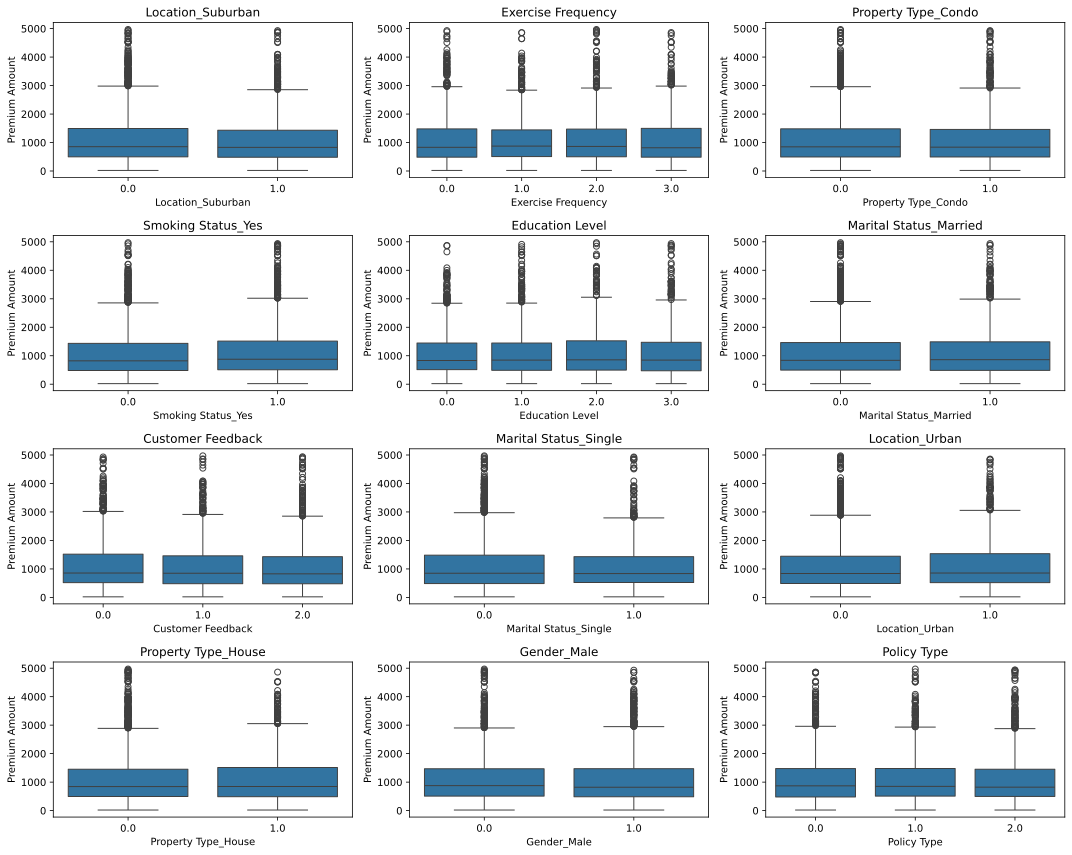

In [102]:
# Разница между params["columns_X"] и params["num_columns"] - это бывшие категориальные признаки, которые были преобразованы методами one-hot и ordinal encoding
columns = list(set(params["columns_X"]) - set(params["num_columns"]))
DataSetLib.show_boxes_plt(dataset_df, columns_x=columns, column_y=params["target_column"])

С одной стороны, значения 'Premium Amount' выше 3000 выглядят как выбросы. С другой - их количество и абсалютные значения наводят на мысль, что это нормальные значения.
Стоит попробовать оба варианта - и удалить их, и оставить.

P.S. Конечный результат практически не зависел от удаления или оставления "выбросов" целевой переменной


## Обработка выбросов в числовых столбцах

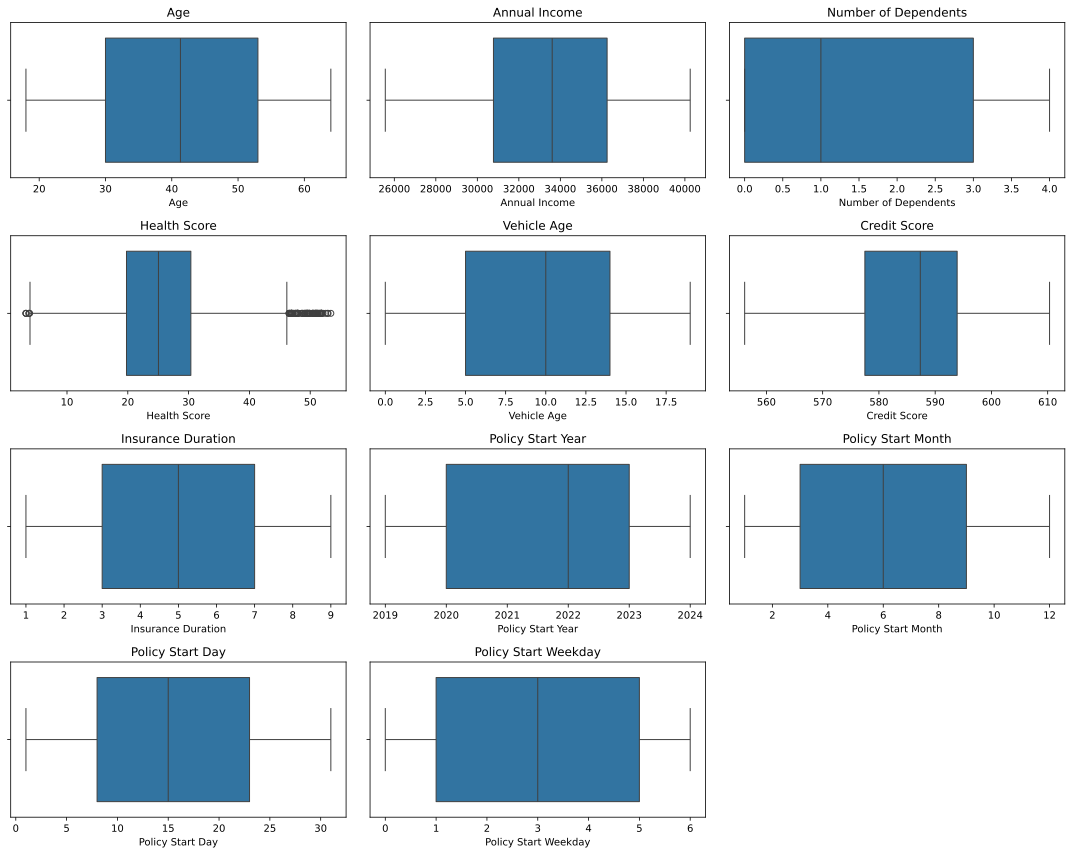

In [103]:
DataSetLib.show_boxes_plt(dataset_df, params["num_columns"])

Выбросы только в столбце `Health Score`, но, судя по количеству и близости значений друг к другу - это скорее нормальные данные, чем выбросы. Оставим их.

# 3. RandomForestRegressor на исходных данных

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay

In [105]:
def rfr_show_feature_importance(model, X_train):
    """Вывести график важности признаков для модели RandomForestRegressor."""
    # Важность признаков
    importances = model.feature_importances_
    features = X_train.columns
    indices = np.argsort(importances)[::-1]

    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.title("Важность признаков (Feature Importances)")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
    plt.xlabel("Признак")
    plt.ylabel("Важность")
    plt.show()

def partial_dependence_plot(model, X_train, X_test):
    """Вывести график PartialDependenceDisplay для модели RandomForestRegressor."""
    importances = model.feature_importances_
    features = X_train.columns
    indices = np.argsort(importances)[::-1]

    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10, 10))
    PartialDependenceDisplay.from_estimator(model, X_test, features=[features[indices[0]]], grid_resolution=50, ax=ax1)
    PartialDependenceDisplay.from_estimator(model, X_test, features=[features[indices[1]]], grid_resolution=50, ax=ax2)
    PartialDependenceDisplay.from_estimator(model, X_test, features=[features[indices[2]]], grid_resolution=50, ax=ax3)
    PartialDependenceDisplay.from_estimator(model, X_test, features=[features[indices[3]]], grid_resolution=50, ax=ax4)
    PartialDependenceDisplay.from_estimator(model, X_test, features=[features[indices[4]]], grid_resolution=50, ax=ax5)
    PartialDependenceDisplay.from_estimator(model, X_test, features=[features[indices[5]]], grid_resolution=50, ax=ax6)
    fig.tight_layout(pad=1.5)
    plt.show()

In [106]:
model_rfr_fe = "rfr"

In [107]:
X_train, X_test, y_train, y_test = train_test_split(dataset_df[params["columns_X"]], 
                                                    dataset_df[params["target_column"]], 
                                                    test_size=0.2, random_state=settings.enviroment["RANDOM_STATE"])

In [108]:
rfr_param_grid = {
    'n_estimators': [50, 75, 100, 125, 150],
    'max_depth': [ 2, 3, 4, 6], #, 8, 10, 15],
    'min_samples_split': [1, 2, 3, 5], #, 8],
    'min_samples_leaf': [3, 4, 5, 6, 7],
    'ccp_alpha': [0.01, 0.02, 0.03] #, 0.05] # 0.0 ccp_alpha
}

In [109]:
# Подобрать гиперпараметры модели
rfr_grid_search =ModelWrapClass.load_or_create_and_fit_GridSearchCV(model_rfr_fe, RandomForestRegressor, rfr_param_grid,
                                                                   X_train, y_train, 
                                                                   settings, scoring='r2', need_save=False,
                                                                   use_randomize_search = False,
                                                                   n_jobs=n_jobs, verbose=verbose)

Создается и выполняется GridSearchCV для модели rfr класса RandomForestRegressor
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


In [110]:
print("Подобранные гиперпараметры модели:")
pd.DataFrame.from_dict(rfr_grid_search.best_params_, orient='index').T

Подобранные гиперпараметры модели:


,ccp_alpha,max_depth,min_samples_leaf,min_samples_split,n_estimators
0,0.03000,2.00000,7.00000,5.00000,100.00000


In [111]:
# Обучить модель и посчитать метрики
rfr_model_wrap = ModelWrapRegression.load_or_create_and_fit_model(model_rfr_fe, 
                                                            RandomForestRegressor,
                                                            rfr_grid_search.best_params_,
                                                            X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
                                                            settings=settings,
                                                            need_save=False)

Создается и тренируется модель rfr класса ABCMeta
Гиперпараметры модели: {'ccp_alpha': 0.03, 'max_depth': 2, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 100}


In [112]:
# Показать метрики
rfr_model_wrap.show_quality()

Train data:
  MSE:    740447.0052
  RMSE:   860.4923
  MAE:    658.0589
  r2:     0.0103
  median: 838.5
Test data:
  MSE:    735485.1166
  RMSE:   857.6043
  MAE:    642.0452
  r2:     -0.0013
  median: 838.5


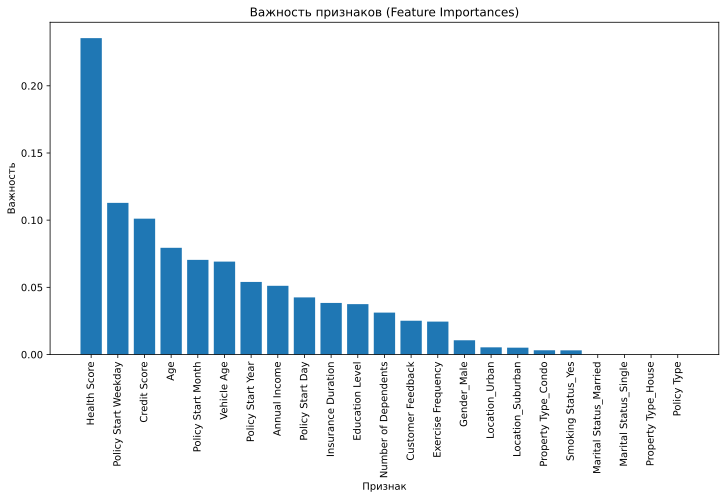

In [113]:
# Показать важность признаков
rfr_show_feature_importance(rfr_model_wrap.model, X_train)

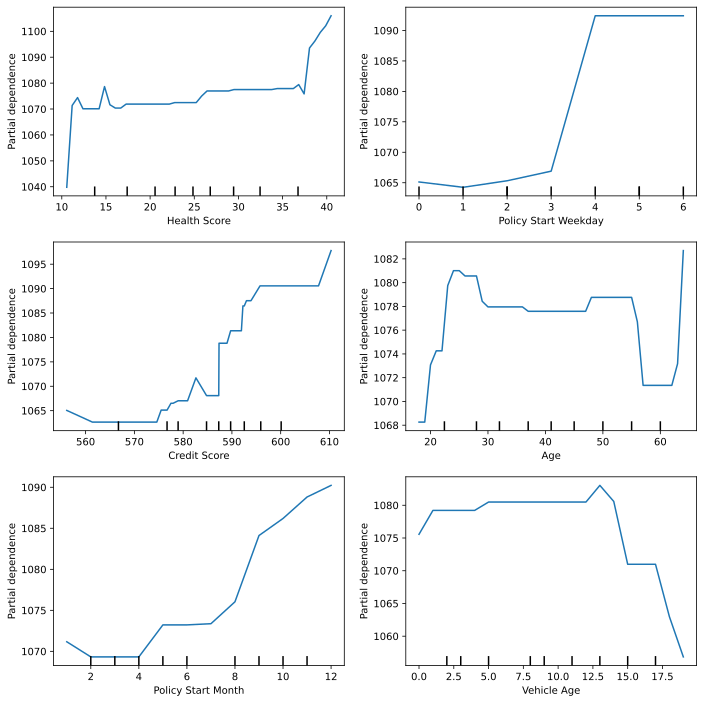

In [114]:
# Показать график графика частичной зависимости
partial_dependence_plot(rfr_model_wrap.model, X_train, X_test)

# 4. Features Engineering

In [115]:
import feature_engine.creation as fe_creation
import feature_engine.imputation as fe_imputation
import feature_engine.datetime as fe_datetime
import feature_engine.encoding as fe_encoding
import feature_engine.selection  as fe_selection

In [116]:
dataset_df_fe = original_dataset_df.copy()
params_fe = DataSetLib.columns_by_type(dataset_df_fe, "Premium Amount")
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(dataset_df_fe[params_fe["columns_X"]], 
                                                    dataset_df_fe[params_fe["target_column"]], 
                                                    test_size=0.2, random_state=settings.enviroment["RANDOM_STATE"])

In [117]:
params_fe_X_train = DataSetLib.columns_by_type(X_train_fe, None)
DataSetLib.describe_columns(X_train_fe, params_fe_X_train)
X_train_fe.sample(5)

Количество уникальных значений по столбцам, доля пропусков и уникальные значения, если их не более 10
Age                 [n]:     47 ( 1.5%)
Gender              [c]:      2        , ['Female', 'Male']
Annual Income       [n]:   3243 ( 3.6%)
Marital Status      [c]:      3 ( 1.5%), ['Married', 'Single', 'Divorced', nan]
Number of Dependents[n]:      5 ( 9.0%), [3.0, 1.0, 4.0, 0.0, 2.0, nan]
Education Level     [c]:      4        , ['PhD', 'High School', "Master's", "Bachelor's"]
Occupation          [c]:      3 (29.5%), ['Unemployed', 'Employed', nan, 'Self-Employed']
Health Score        [n]:   3701 ( 6.3%)
Location            [c]:      3        , ['Rural', 'Urban', 'Suburban']
Policy Type         [c]:      3        , ['Premium', 'Basic', 'Comprehensive']
Previous Claims     [n]:      7 (30.6%), [1.0, 0.0, 2.0, nan, 3.0, 4.0, 5.0, 6.0]
Vehicle Age         [n]:     20        
Credit Score        [n]:    541 (12.3%)
Insurance Duration  [n]:      9        , [3.0, 5.0, 4.0, 8.0, 9.0, 2.0, 7

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration
count,3941.00000,3857.00000,3638.00000,3749.00000,2778.00000,4000.00000,3508.00000,4000.00000
mean,41.36539,33526.91989,2.02941,25.36496,1.01476,9.49050,589.38997,4.99225
std,13.54685,32624.88884,1.42234,12.27782,0.99664,5.74270,151.58853,2.58125
min,18.00000,20.00000,0.00000,3.04978,0.00000,0.00000,300.00000,1.00000
10%,22.00000,2689.00000,0.00000,9.80198,0.00000,2.00000,380.70000,1.00000
25%,30.00000,8078.00000,1.00000,15.66151,0.00000,5.00000,464.75000,3.00000
50%,42.00000,24862.00000,2.00000,24.12122,1.00000,10.00000,588.00000,5.00000
75%,53.00000,45287.00000,3.00000,34.06963,2.00000,14.00000,722.00000,7.00000
90%,60.00000,82419.80000,4.00000,43.23844,2.00000,17.00000,793.00000,9.00000
max,64.00000,149865.00000,4.00000,55.95714,6.00000,19.00000,849.00000,9.00000


,Gender,Marital Status,Education Level,Occupation,Location,Policy Type,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
count,4000,3942,4000,2821,4000,4000,4000,3757,4000,4000,4000
unique,2,3,4,3,3,3,3886,3,2,4,3
top,Male,Married,Bachelor's,Employed,Rural,Premium,2022-05-08 15:21:39.155231,Poor,Yes,Daily,Apartment
freq,2011,1363,1055,986,1370,1396,3,1273,2018,1028,1397


,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
4977,32.00000,Male,135888.00000,Single,4.00000,PhD,Self-Employed,25.69051,Urban,Premium,3.00000,11.00000,706.00000,9.00000,2021-06-08 15:21:39.266452,Poor,Yes,Rarely,House
2757,48.00000,Female,50948.00000,NaN,1.00000,High School,Employed,18.58574,Suburban,Premium,0.00000,9.00000,NaN,6.00000,2021-08-30 15:21:39.209847,Good,Yes,Weekly,House
2954,54.00000,Female,17177.00000,Single,4.00000,High School,NaN,28.73888,Urban,Premium,0.00000,5.00000,652.00000,9.00000,2021-10-20 15:21:39.252145,Good,Yes,Monthly,Condo
1060,59.00000,Female,20959.00000,Divorced,NaN,PhD,Self-Employed,40.63830,Urban,Comprehensive,1.00000,19.00000,600.00000,2.00000,2020-11-02 15:21:39.193945,Poor,No,Daily,House
4744,22.00000,Female,82815.00000,Divorced,3.00000,PhD,NaN,52.86890,Urban,Basic,0.00000,14.00000,704.00000,1.00000,2022-04-29 15:21:39.134960,Good,No,Daily,House


#### Обработка пропусков

Обработка пропусков:
* Age, Annual Income, Health Score, Credit Score  - заполним средним значением
* Number of Dependents, Marital Status и Customer Feedback - модой
* Occupation, Previous Claims - удалить, много пропусков

In [118]:
mmi = fe_imputation.MeanMedianImputer(imputation_method='mean', variables=["Age", "Annual Income", "Health Score", "Credit Score"])
ci = fe_imputation.CategoricalImputer(imputation_method='frequent', variables=["Number of Dependents", "Marital Status", "Customer Feedback"], ignore_format=True)
di = fe_datetime.DatetimeFeatures(variables=["Policy Start Date"], features_to_extract=["year", "month", "day_of_week"], drop_original=True)
dropi = fe_selection.DropFeatures(features_to_drop=["Occupation", "Previous Claims"])

display(dropi.fit(X_train_fe))
X_train_fe = dropi.transform(X_train_fe)
X_test_fe = dropi.transform(X_test_fe)

display(mmi.fit(X_train_fe))
X_train_fe = mmi.transform(X_train_fe)
X_test_fe = mmi.transform(X_test_fe)

display(ci.fit(X_train_fe))
X_train_fe = ci.transform(X_train_fe)
X_test_fe = ci.transform(X_test_fe)

display(di.fit(X_train_fe))
X_train_fe = di.transform(X_train_fe)
X_test_fe = di.transform(X_test_fe)

DropFeatures(features_to_drop=['Occupation', 'Previous Claims'])

MeanMedianImputer(imputation_method='mean',
                  variables=['Age', 'Annual Income', 'Health Score',
                             'Credit Score'])

CategoricalImputer(ignore_format=True, imputation_method='frequent',
                   variables=['Number of Dependents', 'Marital Status',
                              'Customer Feedback'])

DatetimeFeatures(features_to_extract=['year', 'month', 'day_of_week'],
                 variables=['Policy Start Date'])

In [119]:
params_fe_X_train = DataSetLib.columns_by_type(X_train_fe, None)
DataSetLib.describe_columns(X_train_fe, params_fe_X_train)

Количество уникальных значений по столбцам, доля пропусков и уникальные значения, если их не более 10
Age                 [n]:     48        
Gender              [c]:      2        , ['Female', 'Male']
Annual Income       [n]:   3244        
Marital Status      [c]:      3        , ['Married', 'Single', 'Divorced']
Number of Dependents[n]:      5        , [3.0, 1.0, 4.0, 0.0, 2.0]
Education Level     [c]:      4        , ['PhD', 'High School', "Master's", "Bachelor's"]
Health Score        [n]:   3702        
Location            [c]:      3        , ['Rural', 'Urban', 'Suburban']
Policy Type         [c]:      3        , ['Premium', 'Basic', 'Comprehensive']
Vehicle Age         [n]:     20        
Credit Score        [n]:    542        
Insurance Duration  [n]:      9        , [3.0, 5.0, 4.0, 8.0, 9.0, 2.0, 7.0, 6.0, 1.0]
Customer Feedback   [c]:      3        , ['Good', 'Poor', 'Average']
Smoking Status      [c]:      2        , ['Yes', 'No']
Exercise Frequency  [c]:      4        , ['M

,Age,Annual Income,Number of Dependents,Health Score,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date_year,Policy Start Date_month,Policy Start Date_day_of_week
count,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000
mean,41.36539,33526.91989,2.20775,25.36496,9.49050,589.38997,4.99225,2021.61475,6.34925,2.99075
std,13.44655,32036.26306,1.46957,11.88627,5.74270,141.95756,2.58125,1.46948,3.41463,1.97880
min,18.00000,20.00000,0.00000,3.04978,0.00000,300.00000,1.00000,2019.00000,1.00000,0.00000
10%,22.00000,2783.50000,0.00000,9.92470,2.00000,389.00000,1.00000,2020.00000,2.00000,0.00000
25%,30.00000,8959.75000,1.00000,16.09715,5.00000,481.00000,3.00000,2020.00000,3.00000,1.00000
50%,41.36539,25602.00000,2.00000,25.36496,10.00000,589.38997,5.00000,2022.00000,6.00000,3.00000
75%,53.00000,44704.25000,4.00000,33.26768,14.00000,704.00000,7.00000,2023.00000,9.00000,5.00000
90%,60.00000,81505.30000,4.00000,42.81565,17.00000,786.00000,9.00000,2024.00000,11.00000,6.00000
max,64.00000,149865.00000,4.00000,55.95714,19.00000,849.00000,9.00000,2024.00000,12.00000,6.00000


,Gender,Marital Status,Education Level,Location,Policy Type,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
count,4000,4000,4000,4000,4000,4000,4000,4000,4000
unique,2,3,4,3,3,3,2,4,3
top,Male,Married,Bachelor's,Rural,Premium,Poor,Yes,Daily,Apartment
freq,2011,1421,1055,1370,1396,1516,2018,1028,1397


#### Кодирование признаков

In [120]:
# столбцы для one-hot-encoding
onehot_columns = ['Gender', "Marital Status", "Location", "Property Type", "Smoking Status"]
# Столбцы для ordinal-encoding
ordered_columns = {"Education Level": ["High School", "Bachelor's", "Master's", "PhD"],
                   "Policy Type": ['Basic', 'Comprehensive', 'Premium'],
                   "Customer Feedback": ['Poor', 'Average', 'Good'],
                   "Exercise Frequency": ['Rarely', 'Weekly', 'Monthly', 'Daily']}


In [121]:
X_train_fe.sample(7, random_state=settings.enviroment["RANDOM_STATE"])

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Health Score,Location,Policy Type,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Policy Start Date_year,Policy Start Date_month,Policy Start Date_day_of_week
682,24.00000,Male,78832.00000,Divorced,2.00000,High School,8.65347,Rural,Basic,8.00000,511.00000,1.00000,Poor,Yes,Weekly,Apartment,2020,3,6
4312,41.36539,Male,35796.00000,Divorced,0.00000,PhD,15.83726,Rural,Comprehensive,1.00000,468.00000,4.00000,Good,No,Monthly,Condo,2020,4,0
647,58.00000,Male,129871.00000,Married,1.00000,High School,13.28597,Rural,Basic,13.00000,340.00000,8.00000,Average,Yes,Rarely,House,2022,4,1
878,38.00000,Male,3907.00000,Married,2.00000,Bachelor's,24.86789,Urban,Basic,2.00000,728.00000,6.00000,Average,No,Daily,House,2022,12,5
777,26.00000,Female,17069.00000,Married,4.00000,Master's,11.94211,Urban,Basic,8.00000,830.00000,8.00000,Poor,No,Daily,Apartment,2023,4,1
2673,62.00000,Male,33266.00000,Divorced,2.00000,Bachelor's,25.36496,Urban,Premium,16.00000,392.00000,7.00000,Poor,No,Rarely,House,2022,10,0
1423,41.36539,Female,87940.00000,Single,2.00000,Master's,20.24674,Rural,Basic,3.00000,492.00000,4.00000,Poor,Yes,Daily,Condo,2023,7,5


In [122]:
onhe = fe_encoding.OneHotEncoder(variables=onehot_columns, drop_last=True)
display(onhe.fit(X_train_fe))
X_train_fe = onhe.transform(X_train_fe)
X_test_fe = onhe.transform(X_test_fe)

OneHotEncoder(drop_last=True,
              variables=['Gender', 'Marital Status', 'Location',
                         'Property Type', 'Smoking Status'])

In [123]:
X_train_fe.sample(7, random_state=settings.enviroment["RANDOM_STATE"])

,Age,Annual Income,Number of Dependents,Education Level,Health Score,Policy Type,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Exercise Frequency,Policy Start Date_year,Policy Start Date_month,Policy Start Date_day_of_week,Gender_Female,Marital Status_Married,Marital Status_Single,Location_Rural,Location_Urban,Property Type_Apartment,Property Type_House,Smoking Status_Yes
682,24.00000,78832.00000,2.00000,High School,8.65347,Basic,8.00000,511.00000,1.00000,Poor,Weekly,2020,3,6,0,0,0,1,0,1,0,1
4312,41.36539,35796.00000,0.00000,PhD,15.83726,Comprehensive,1.00000,468.00000,4.00000,Good,Monthly,2020,4,0,0,0,0,1,0,0,0,0
647,58.00000,129871.00000,1.00000,High School,13.28597,Basic,13.00000,340.00000,8.00000,Average,Rarely,2022,4,1,0,1,0,1,0,0,1,1
878,38.00000,3907.00000,2.00000,Bachelor's,24.86789,Basic,2.00000,728.00000,6.00000,Average,Daily,2022,12,5,0,1,0,0,1,0,1,0
777,26.00000,17069.00000,4.00000,Master's,11.94211,Basic,8.00000,830.00000,8.00000,Poor,Daily,2023,4,1,1,1,0,0,1,1,0,0
2673,62.00000,33266.00000,2.00000,Bachelor's,25.36496,Premium,16.00000,392.00000,7.00000,Poor,Rarely,2022,10,0,0,0,0,0,1,0,1,0
1423,41.36539,87940.00000,2.00000,Master's,20.24674,Basic,3.00000,492.00000,4.00000,Poor,Daily,2023,7,5,1,0,1,1,0,0,0,1


In [124]:
X_train_fe = X_train_fe.copy()
X_test_fe = X_test_fe.copy()
print(list(ordered_columns.keys()))

orhe = fe_encoding.OrdinalEncoder(encoding_method='arbitrary', variables=list(ordered_columns.keys()), )
display(orhe.fit(X_train_fe))
X_train_fe = orhe.transform(X_train_fe)
X_test_fe = orhe.transform(X_test_fe)


['Education Level', 'Policy Type', 'Customer Feedback', 'Exercise Frequency']


OrdinalEncoder(encoding_method='arbitrary',
               variables=['Education Level', 'Policy Type', 'Customer Feedback',
                          'Exercise Frequency'])

In [125]:
params_fe = DataSetLib.columns_by_type(X_train_fe, None)
DataSetLib.describe_columns(X_train_fe, params_fe)

Количество уникальных значений по столбцам, доля пропусков и уникальные значения, если их не более 10
Age                 [n]:     48        
Annual Income       [n]:   3244        
Number of Dependents[n]:      5        , [3.0, 1.0, 4.0, 0.0, 2.0]
Education Level     [n]:      4        , [0, 1, 2, 3]
Health Score        [n]:   3702        
Policy Type         [n]:      3        , [0, 1, 2]
Vehicle Age         [n]:     20        
Credit Score        [n]:    542        
Insurance Duration  [n]:      9        , [3.0, 5.0, 4.0, 8.0, 9.0, 2.0, 7.0, 6.0, 1.0]
Customer Feedback   [n]:      3        , [0, 1, 2]
Exercise Frequency  [n]:      4        , [0, 1, 2, 3]
Policy Start Date_year[n]:      6        , [2020, 2024, 2023, 2019, 2022, 2021]
Policy Start Date_month[n]:     12        
Policy Start Date_day_of_week[n]:      7        , [3, 0, 1, 4, 2, 6, 5]
Gender_Female       [c]:      2        , [1, 0]
Marital Status_Married[c]:      2        , [1, 0]
Marital Status_Single[c]:      2        ,

,Age,Annual Income,Number of Dependents,Education Level,Health Score,Policy Type,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Exercise Frequency,Policy Start Date_year,Policy Start Date_month,Policy Start Date_day_of_week
count,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000
mean,41.36539,33526.91989,2.20775,1.54925,25.36496,0.97900,9.49050,589.38997,4.99225,1.01400,1.50600,2021.61475,6.34925,2.99075
std,13.44655,32036.26306,1.46957,1.11552,11.88627,0.82263,5.74270,141.95756,2.58125,0.78801,1.11300,1.46948,3.41463,1.97880
min,18.00000,20.00000,0.00000,0.00000,3.04978,0.00000,0.00000,300.00000,1.00000,0.00000,0.00000,2019.00000,1.00000,0.00000
10%,22.00000,2783.50000,0.00000,0.00000,9.92470,0.00000,2.00000,389.00000,1.00000,0.00000,0.00000,2020.00000,2.00000,0.00000
25%,30.00000,8959.75000,1.00000,1.00000,16.09715,0.00000,5.00000,481.00000,3.00000,0.00000,1.00000,2020.00000,3.00000,1.00000
50%,41.36539,25602.00000,2.00000,2.00000,25.36496,1.00000,10.00000,589.38997,5.00000,1.00000,2.00000,2022.00000,6.00000,3.00000
75%,53.00000,44704.25000,4.00000,3.00000,33.26768,2.00000,14.00000,704.00000,7.00000,2.00000,2.00000,2023.00000,9.00000,5.00000
90%,60.00000,81505.30000,4.00000,3.00000,42.81565,2.00000,17.00000,786.00000,9.00000,2.00000,3.00000,2024.00000,11.00000,6.00000
max,64.00000,149865.00000,4.00000,3.00000,55.95714,2.00000,19.00000,849.00000,9.00000,2.00000,3.00000,2024.00000,12.00000,6.00000


,Gender_Female,Marital Status_Married,Marital Status_Single,Location_Rural,Location_Urban,Property Type_Apartment,Property Type_House,Smoking Status_Yes
count,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000
mean,0.49725,0.35525,0.32325,0.34250,0.32125,0.34925,0.32575,0.50450
std,0.50005,0.47865,0.46778,0.47461,0.46701,0.47679,0.46871,0.50004
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
75%,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


### Генерация фич

In [126]:
columns_for_math =  [["Annual Income", "Number of Dependents"],
                     ["Health Score", "Annual Income"],
                     ["Credit Score", "Annual Income"],
                     ["Vehicle Age", "Health Score"],
                     ["Annual Income", "Credit Score", "Number of Dependents"],
                     ["Vehicle Age", "Credit Score","Annual Income"],
                     ["Vehicle Age", "Credit Score","Health Score"],
                     ["Annual Income", "Credit Score","Number of Dependents"]]

for clms in columns_for_math:
    # Создание экземпляра класса MathematicalCombination -> MathFeatures
    # для генерации новых признаков путем математических операций
    mf = fe_creation.MathFeatures(
        variables=clms, 
        func=["sum", "min", "max", "std"]
    )
    mf.fit(X_train_fe)
    X_train_fe = mf.transform(X_train_fe)
    X_test_fe = mf.transform(X_test_fe)

In [127]:
X_train_fe.sample(7, random_state=settings.enviroment["RANDOM_STATE"])

,Age,Annual Income,Number of Dependents,Education Level,Health Score,Policy Type,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Exercise Frequency,Policy Start Date_year,Policy Start Date_month,Policy Start Date_day_of_week,Gender_Female,Marital Status_Married,Marital Status_Single,Location_Rural,Location_Urban,Property Type_Apartment,Property Type_House,Smoking Status_Yes,sum_Annual Income_Number of Dependents,min_Annual Income_Number of Dependents,max_Annual Income_Number of Dependents,std_Annual Income_Number of Dependents,sum_Health Score_Annual Income,min_Health Score_Annual Income,max_Health Score_Annual Income,std_Health Score_Annual Income,sum_Credit Score_Annual Income,min_Credit Score_Annual Income,max_Credit Score_Annual Income,std_Credit Score_Annual Income,sum_Vehicle Age_Health Score,min_Vehicle Age_Health Score,max_Vehicle Age_Health Score,std_Vehicle Age_Health Score,sum_Annual Income_Credit Score_Number of Dependents,min_Annual Income_Credit Score_Number of Dependents,max_Annual Income_Credit Score_Number of Dependents,std_Annual Income_Credit Score_Number of Dependents,sum_Vehicle Age_Credit Score_Annual Income,min_Vehicle Age_Credit Score_Annual Income,max_Vehicle Age_Credit Score_Annual Income,std_Vehicle Age_Credit Score_Annual Income,sum_Vehicle Age_Credit Score_Health Score,min_Vehicle Age_Credit Score_Health Score,max_Vehicle Age_Credit Score_Health Score,std_Vehicle Age_Credit Score_Health Score
682,24.00000,78832.00000,2.00000,1,8.65347,1,8.00000,511.00000,1.00000,1,1,2020,3,6,0,0,0,1,0,1,0,1,78834.00000,2.00000,78832.00000,55741.22756,78840.65347,8.65347,78832.00000,55736.52285,79343.00000,511.00000,78832.00000,55381.31021,16.65347,8.00000,8.65347,0.46207,79345.00000,2.00000,78832.00000,45366.29994,79351.00000,8.00000,78832.00000,45364.55119,527.65347,8.00000,511.00000,290.21873
4312,41.36539,35796.00000,0.00000,0,15.83726,2,1.00000,468.00000,4.00000,0,0,2020,4,0,0,0,0,1,0,0,0,0,35796.00000,0.00000,35796.00000,25311.59434,35811.83726,15.83726,35796.00000,25300.39571,36264.00000,468.00000,35796.00000,24980.66837,16.83726,1.00000,15.83726,10.49153,36264.00000,0.00000,35796.00000,20533.06368,36265.00000,1.00000,35796.00000,20532.76933,484.83726,1.00000,468.00000,265.44312
647,58.00000,129871.00000,1.00000,1,13.28597,1,13.00000,340.00000,8.00000,2,3,2022,4,1,0,1,0,1,0,0,1,1,129872.00000,1.00000,129871.00000,91831.95767,129884.28597,13.28597,129871.00000,91823.27018,130211.00000,340.00000,129871.00000,91592.24847,26.28597,13.00000,13.28597,0.20221,130212.00000,1.00000,129871.00000,74882.81042,130224.00000,13.00000,129871.00000,74879.33299,366.28597,13.00000,340.00000,188.71104
878,38.00000,3907.00000,2.00000,3,24.86789,1,2.00000,728.00000,6.00000,2,2,2022,12,5,0,1,0,0,1,0,1,0,3909.00000,2.00000,3907.00000,2761.25198,3931.86789,24.86789,3907.00000,2745.08194,4635.00000,728.00000,3907.00000,2247.89246,26.86789,2.00000,24.86789,16.17004,4637.00000,2.00000,3907.00000,2076.94254,4637.00000,2.00000,3907.00000,2076.94254,754.86789,2.00000,728.00000,412.71332
777,26.00000,17069.00000,4.00000,2,11.94211,1,8.00000,830.00000,8.00000,1,2,2023,4,1,1,1,0,0,1,1,0,0,17073.00000,4.00000,17069.00000,12066.77722,17080.94211,11.94211,17069.00000,12061.16130,17899.00000,830.00000,17069.00000,11482.70702,19.94211,8.00000,11.94211,2.78749,17903.00000,4.00000,17069.00000,9622.90343,17907.00000,8.00000,17069.00000,9621.66415,849.94211,8.00000,830.00000,473.44804
2673,62.00000,33266.00000,2.00000,3,25.36496,0,16.00000,392.00000,7.00000,1,3,2022,10,0,0,0,0,0,1,0,1,0,33268.00000,2.00000,33266.00000,23521.19997,33291.36496,25.36496,33266.00000,23504.67845,33658.00000,392.00000,33266.00000,23245.42832,41.36496,16.00000,25.36496,6.62203,33660.00000,2.00000,33266.00000,19093.39184,33674.00000,16.00000,33266.00000,19089.28038,433.36496,16.00000,392.00000,214.43140
1423,41.36539,87940.00000,2.00000,2,20.24674,1,3.00000,492.00000,4.00000,1,2,2023,7,5,1,0,1,1,0,0,0,1,87942.00000,2.00000,87940.00000,62181.55612,87960.24674,20.

# 5. RandomForestRegressor на сгенерированных данных

In [128]:
model_rfr_fe = "rfr_fe"

In [129]:
# Создание и обучение модели дерева решений с поиском по сетке
rfr_param_grid_fe = {
    'n_estimators': [100, 125, 150, 175],
    'max_depth': [1, 2, 3], #, 4, 6, 8, 10, 15],
    'min_samples_split': [1, 2, 3], #, 5, 8],
    'min_samples_leaf': [7, 8, 9, 11],
    'ccp_alpha': [0.01, 0.02, 0.03], #, 0.05] # 0.0 ccp_alpha
    'random_state': [settings.enviroment["RANDOM_STATE"]]
}

In [130]:
# Подобрать гиперпараметры модели
rfr_grid_search_fe =ModelWrapClass.load_or_create_and_fit_GridSearchCV(model_rfr_fe, RandomForestRegressor, rfr_param_grid_fe,
                                                                   X_train_fe, y_train_fe, 
                                                                   settings, scoring='r2', need_save=False,
                                                                   use_randomize_search = False,
                                                                   n_jobs=n_jobs, verbose=verbose)

Создается и выполняется GridSearchCV для модели rfr_fe класса RandomForestRegressor
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [131]:
print("Подобранные гиперпараметры модели:")
pd.DataFrame.from_dict(rfr_grid_search_fe.best_params_, orient='index').T

Подобранные гиперпараметры модели:


,ccp_alpha,max_depth,min_samples_leaf,min_samples_split,n_estimators,random_state
0,0.01000,1.00000,11.00000,2.00000,175.00000,42.00000


In [132]:
# Обучить модель и посчитать метрики
rfr_fe_model = ModelWrapRegression.load_or_create_and_fit_model(model_rfr_fe, 
                                                            RandomForestRegressor,
                                                            rfr_grid_search_fe.best_params_,
                                                            X_train=X_train_fe, X_test=X_test_fe, y_train=y_train_fe, y_test=y_test_fe,
                                                            settings=settings,
                                                            need_save=False)

Создается и тренируется модель rfr_fe класса ABCMeta
Гиперпараметры модели: {'ccp_alpha': 0.01, 'max_depth': 1, 'min_samples_leaf': 11, 'min_samples_split': 2, 'n_estimators': 175, 'random_state': 42}


In [133]:
# Показать метрики
rfr_fe_model.show_quality()

Train data:
  MSE:    742440.5833
  RMSE:   861.6499
  MAE:    658.7988
  r2:     0.0077
  median: 838.5
Test data:
  MSE:    736189.25
  RMSE:   858.0147
  MAE:    643.3254
  r2:     -0.0023
  median: 838.5


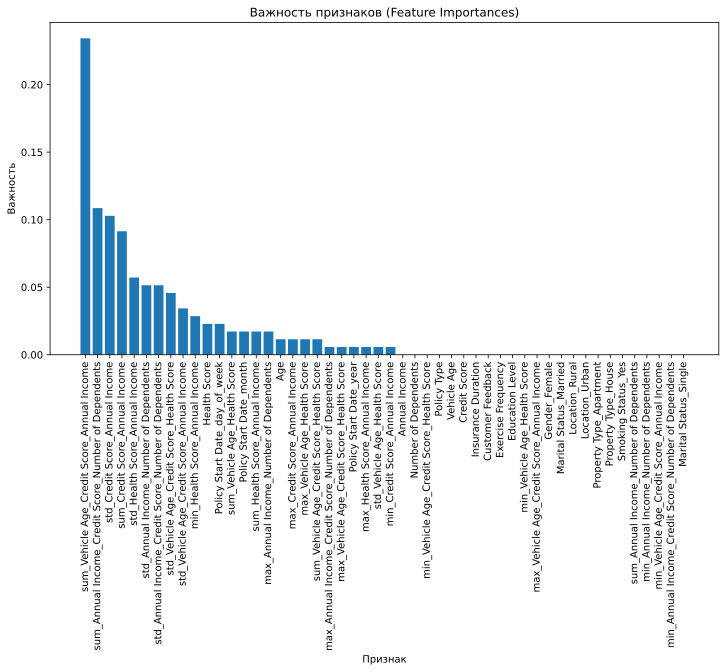

In [134]:
# Показать важность признаков
rfr_show_feature_importance(rfr_fe_model.model, X_train_fe)

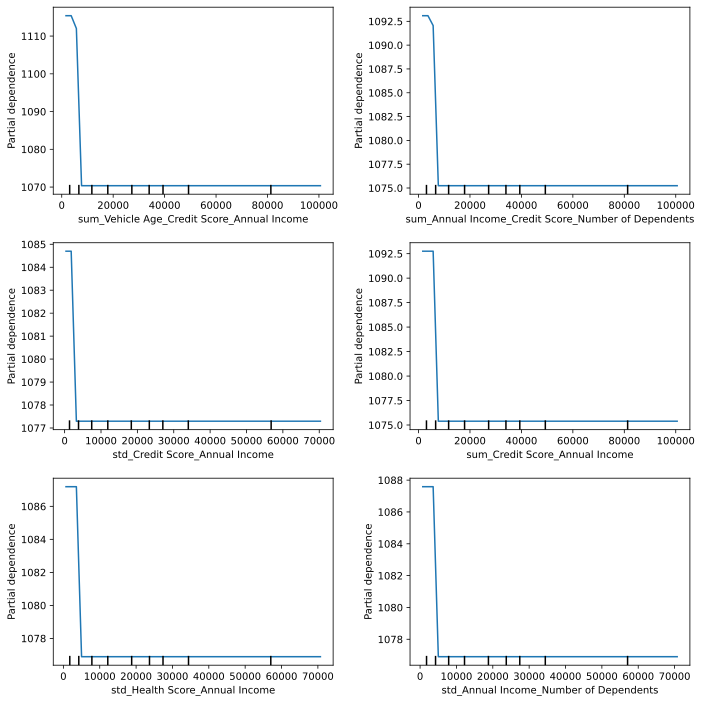

In [135]:
# Показать график графика частичной зависимости
partial_dependence_plot(rfr_fe_model.model, X_train_fe, X_test_fe)

# 6. Сравнение метрик

In [136]:
stat = ModelWrapBase.compare_metrcis([rfr_model_wrap, rfr_fe_model])
stat

params,model_name,Train_MSE,Test_MSE,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_R2,Test_R2,Train_median,Test_Median
0,rfr,740447.00517,735485.11659,860.49230,857.60429,658.05886,642.04521,0.01032,-0.00133,838.50000,838.50000
1,rfr_fe,742440.58328,736189.24995,861.64992,858.01471,658.79884,643.32539,0.00765,-0.00229,838.50000,838.50000


Обе модели показывают плохие результаты - r2_score близка к 0. Использовать для предсказания нельзя.